In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import __version__
print("scikit-learn version "+str(__version__) + "(>= 0.18 required)")

scikit-learn version 0.18(>= 0.18 required)


# All-features regressions on Alpine Plant data

We first load the data and examine the features within:

In [2]:
plants_master = pd.read_csv("plants5.csv")
print(plants_master.columns.values) 

['Taxon' 'migration_m' 'migr_sterr_m' 'shift + 2SE' 'signif_shift'
 'signif_shift2' 'StorageOrgan' 'ReprModeCode' 'flwr_mo_start'
 'flwr_mo_end' 'flwr_dur_mos' 'earliest_seed_shed_mo' 'latest_seed_shed_mo'
 'seed_shed_dur_mos' 'SI01' 'BreedSysCode' 'seed_mass_mg'
 'diaspore_mass_mg' 'dispersal_mode' 'dispmode01' 'diaspore_min_len_mm'
 'diaspore_max_len_mm' 'diaspore_ave_len_mm' 'Min_seed_shed_ht_m'
 'Max_seed_shed_ht_m' 'Ave_seed_shed_ht_m' 'Grime'
 'nichebreadth_num_flor_zones' 'oceanity' 'nichebreadth_amplit_ocean'
 'Bio1_mean_nosyn' 'Bio1_std_nosyn' 'Bio1_var_nosyn' 'Bio1_mean_inclsyn'
 'Bio1_std_inclsyn' 'Bio1_var_inclsyn' 'Nbound_lat_GBIF_nosyn'
 'DispModeEng' 'GenTime' 'Resil' 'MaxAlt']


Let's take a closer look:


Then we must process the data in the following ways:

1. Drop features with direct relationship to modeled variable (see `drop_features`)
2. Convert categorical features into [one-hot encoding](http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/). We must do this because although the data set already has converted certain categorical features into an encoding, the ordered encoding used (i.e. 1 = gravity, 2= wind for dispersal) gives arbitrary ordering to the data. This cannot be. We use one-hot encoding to alleviate this. 
3. We can choose whether to filter the data based on significance (the `signif_shift` field), but there's no documentation for that field so we forego that for now
4. These machine learning algorithms cannot handle N/A or NaN fields, so we remove all rows that contain any N/A fields. This is problematic but we'll start here. 


In [3]:
from sklearn.preprocessing import Imputer

drop_features = ["Taxon",
                 "migr_sterr_m", 
                 "shift + 2SE", 
                 'signif_shift',
                 "signif_shift2",
                 "dispmode01",
                 "DispModeEng", ## what is this
                 "shift + 2SE",
                ]


categorical_features = ["oceanity", "dispersal_mode", "BreedSysCode", "Grime"]

## convert noncoded categorical variables into one-hot encoding
plants = pd.get_dummies(plants_master, columns=categorical_features)



# features_sig = plants.loc[plants["signif_shift"] == 1].drop(drop_features, axis=1)
# features_sig = features_sig.dropna(axis=0)
# target_sig   = features_sig.loc[plants["signif_shift"] == 1]["migration_m"]

features = plants.drop(drop_features, axis=1)
beforenona = set(features.columns.values)
## axis = 1 drops columns with any NAs, axis = 0 drops rows with any NAs
features = features.dropna(axis=0)
afternona  = set(features.columns.values)
target   = features["migration_m"]
features.drop(["migration_m"], inplace=True, axis=1)

print("Number of Entries: " + str(len(features)))
print("Cols removed: " + str((beforenona-afternona)))

Number of Entries: 20
Cols removed: set()


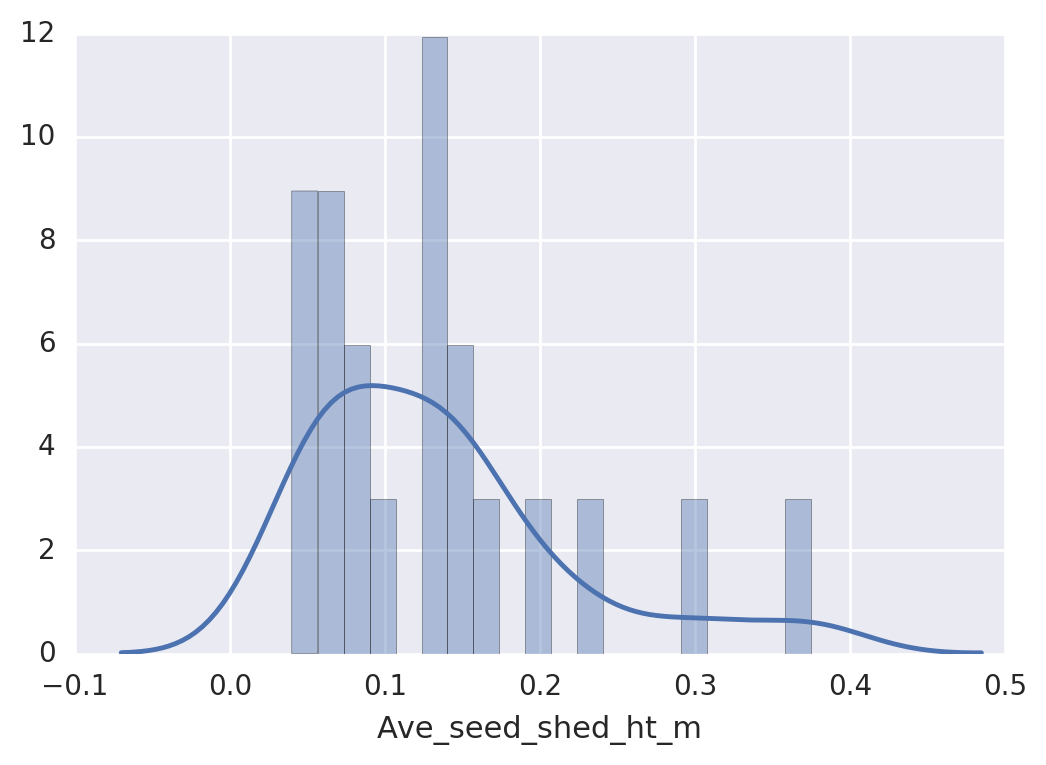

In [4]:
sns.distplot(features["Ave_seed_shed_ht_m"], bins=20)

Here we develop two functions for plotting feature importances for the Decision Tree algorithms. 

In [5]:
def importances(weights, features):
    """
    sorts features array based on weights.
    """
    assert(len(weights) == len(features.columns))
    sorted_importances = np.argsort(weights)
    return list(zip(features.columns.values[sorted_importances[::-1]],
                weights[sorted_importances[::-1]]))

def plot_importances(weights, features):
    names, values = zip(*importances(weights, features))
    fig, ax = plt.subplots()
    xlabels = np.arange(len(features.columns))
    ax.bar(xlabels, values)
    ax.set_ylabel("Norm. Variable Importance")
    ax.set_xticks(xlabels)
    ax.set_xticklabels(names, rotation=70)
    plt.tight_layout()

## Decision Tree Regression

Now we can use [Decision Tree Regression](http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) as an initial attempt. The output of the regression is a Decision Tree and a set of feature importances as defined in the documentation linked above:

> The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance [R249](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm ).


[('earliest_seed_shed_mo', 0.43232225846632927),
 ('Ave_seed_shed_ht_m', 0.16826829836602164),
 ('latest_seed_shed_mo', 0.15636731845988769),
 ('diaspore_max_len_mm', 0.080524585241928445),
 ('diaspore_ave_len_mm', 0.067479563063245415),
 ('seed_mass_mg', 0.056787872107586831),
 ('flwr_dur_mos', 0.01432573805281582),
 ('Bio1_var_inclsyn', 0.013093731556527891),
 ('flwr_mo_end', 0.0078064284787439679),
 ('nichebreadth_amplit_ocean', 0.0030242062069129098),
 ('Max_seed_shed_ht_m', 0.0),
 ('Bio1_var_nosyn', 0.0),
 ('Bio1_std_nosyn', 0.0),
 ('Bio1_mean_nosyn', 0.0),
 ('nichebreadth_num_flor_zones', 0.0),
 ('diaspore_min_len_mm', 0.0),
 ('Min_seed_shed_ht_m', 0.0),
 ('Bio1_std_inclsyn', 0.0),
 ('diaspore_mass_mg', 0.0),
 ('SI01', 0.0),
 ('seed_shed_dur_mos', 0.0),
 ('flwr_mo_start', 0.0),
 ('ReprModeCode', 0.0),
 ('Bio1_mean_inclsyn', 0.0),
 ('Grime_sr', 0.0),
 ('Grime_s', 0.0),
 ('Nbound_lat_GBIF_nosyn', 0.0),
 ('Grime_r', 0.0),
 ('Grime_csr', 0.0),
 ('Grime_cs', 0.0),
 ('Grime_c', 0.0),
 

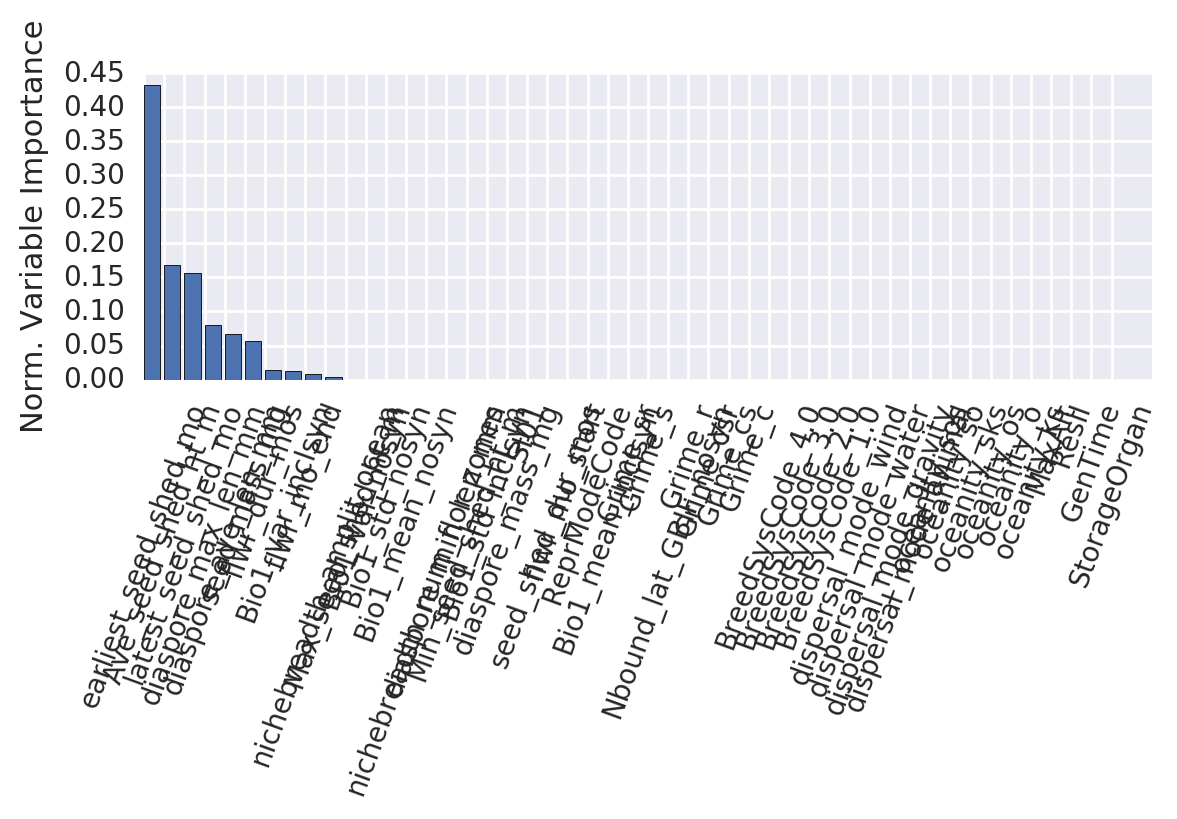

In [6]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz



dtr = DecisionTreeRegressor(max_depth=6)
dtr.fit(features, target)

plot_importances(dtr.feature_importances_, features)        
importances(dtr.feature_importances_, features)



[Random Forest Regression](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) creates an ensemble of decision trees and uses them together to produce a regression. It also outputs feature importances, which are of interest. 

## Random Forest Regression

[Random Forest Regression](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) creates an ensemble of decision trees and uses them together to produce a regression. It also outputs feature importances, which are of interest. 


[('earliest_seed_shed_mo', 0.4048229162981386),
 ('latest_seed_shed_mo', 0.13784459931587181),
 ('Nbound_lat_GBIF_nosyn', 0.083426645706897062),
 ('Bio1_mean_nosyn', 0.0771181533483382),
 ('flwr_dur_mos', 0.061905841706888107),
 ('diaspore_ave_len_mm', 0.027167212859050827),
 ('Bio1_mean_inclsyn', 0.025908991756560806),
 ('seed_mass_mg', 0.024477569797113678),
 ('diaspore_min_len_mm', 0.021216711816245248),
 ('oceanity_os', 0.02008027206493284),
 ('Bio1_var_nosyn', 0.0190226970469583),
 ('diaspore_mass_mg', 0.018295233444304535),
 ('flwr_mo_end', 0.01293439373464747),
 ('Grime_s', 0.012689805274875876),
 ('BreedSysCode_4.0', 0.012424982776975135),
 ('Bio1_std_inclsyn', 0.0062993584844484515),
 ('Max_seed_shed_ht_m', 0.0058442635666470042),
 ('MaxAlt', 0.005320442453674001),
 ('Ave_seed_shed_ht_m', 0.0050081530605371591),
 ('ReprModeCode', 0.0032781654687680855),
 ('Bio1_std_nosyn', 0.0027870071159742937),
 ('seed_shed_dur_mos', 0.0025483823589247958),
 ('dispersal_mode_animal', 0.00226

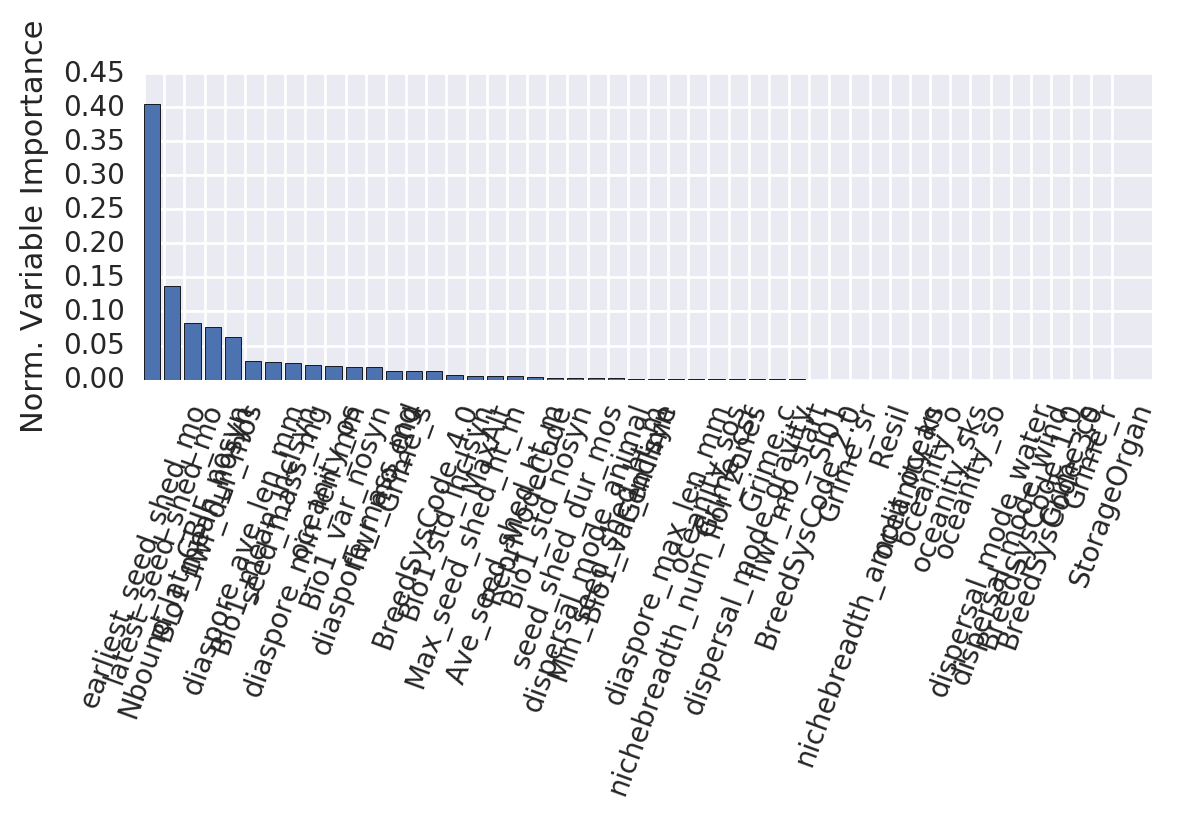

In [7]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(features, target)
plot_importances(rfr.feature_importances_, features)
importances(rfr.feature_importances_, features)


##Support Vector Regression

In [8]:
from sklearn.svm import SVR
svr_rbf = SVR(C = 1e4, epsilon=0.1, kernel='rbf')
svr_rbf.fit(features, target)
svr_rbf.score(features, target)

0.99958338411155501

## Bayesian Ridge Regression <small>all features</small>

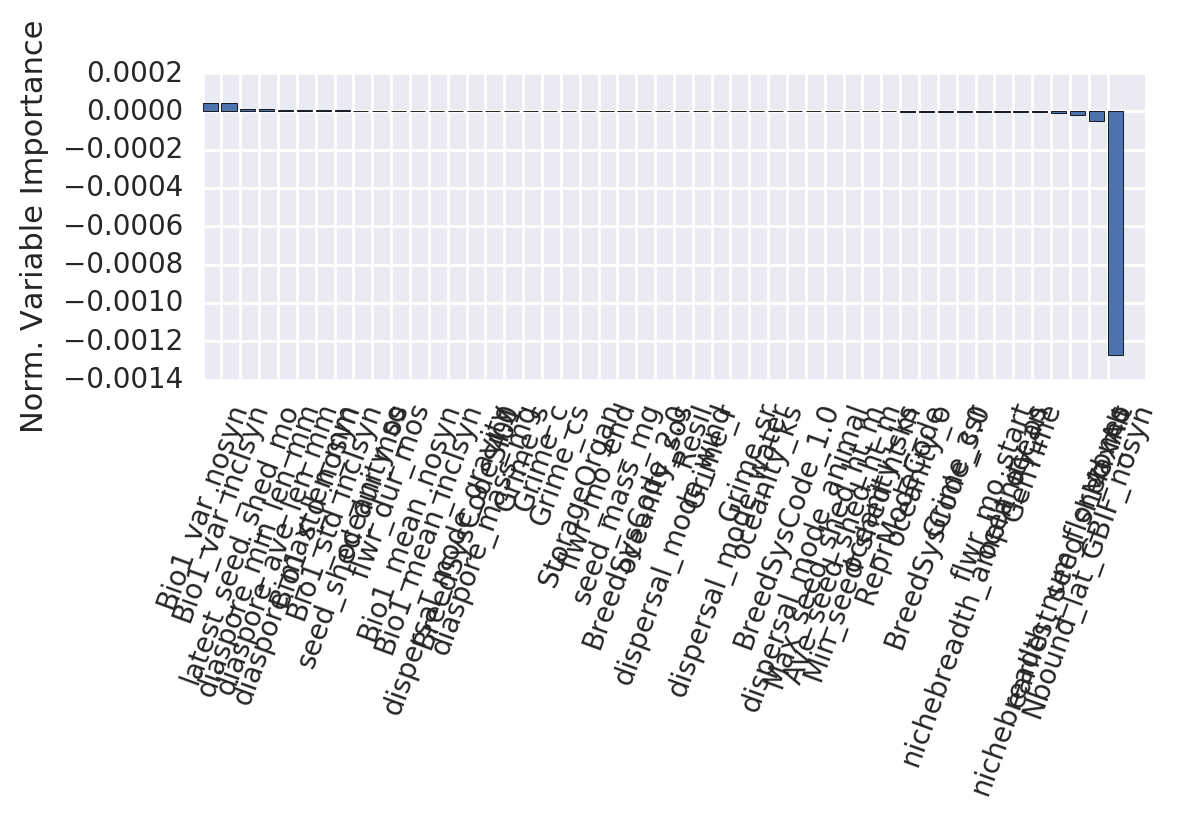

In [9]:
from sklearn.linear_model import BayesianRidge
brr = BayesianRidge()

brr.fit(features, target)
brr.score(features, target)
plot_importances(brr.coef_, features)

# Single-Feature Regressions

## Support Vector Regressions

In [10]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

## POLYNOMAL KERNEL IS SLOW
svr_rbf = SVR(C = 1e3, epsilon = 0.1, kernel='rbf')
model = svr_rbf

In [11]:
test_data = plants_master.drop(["Taxon", "migr_sterr_m", "shift + 2SE"]+categorical_features, axis=1)

test_data.dropna(axis=0, inplace=True)
test_features = test_data.columns.values


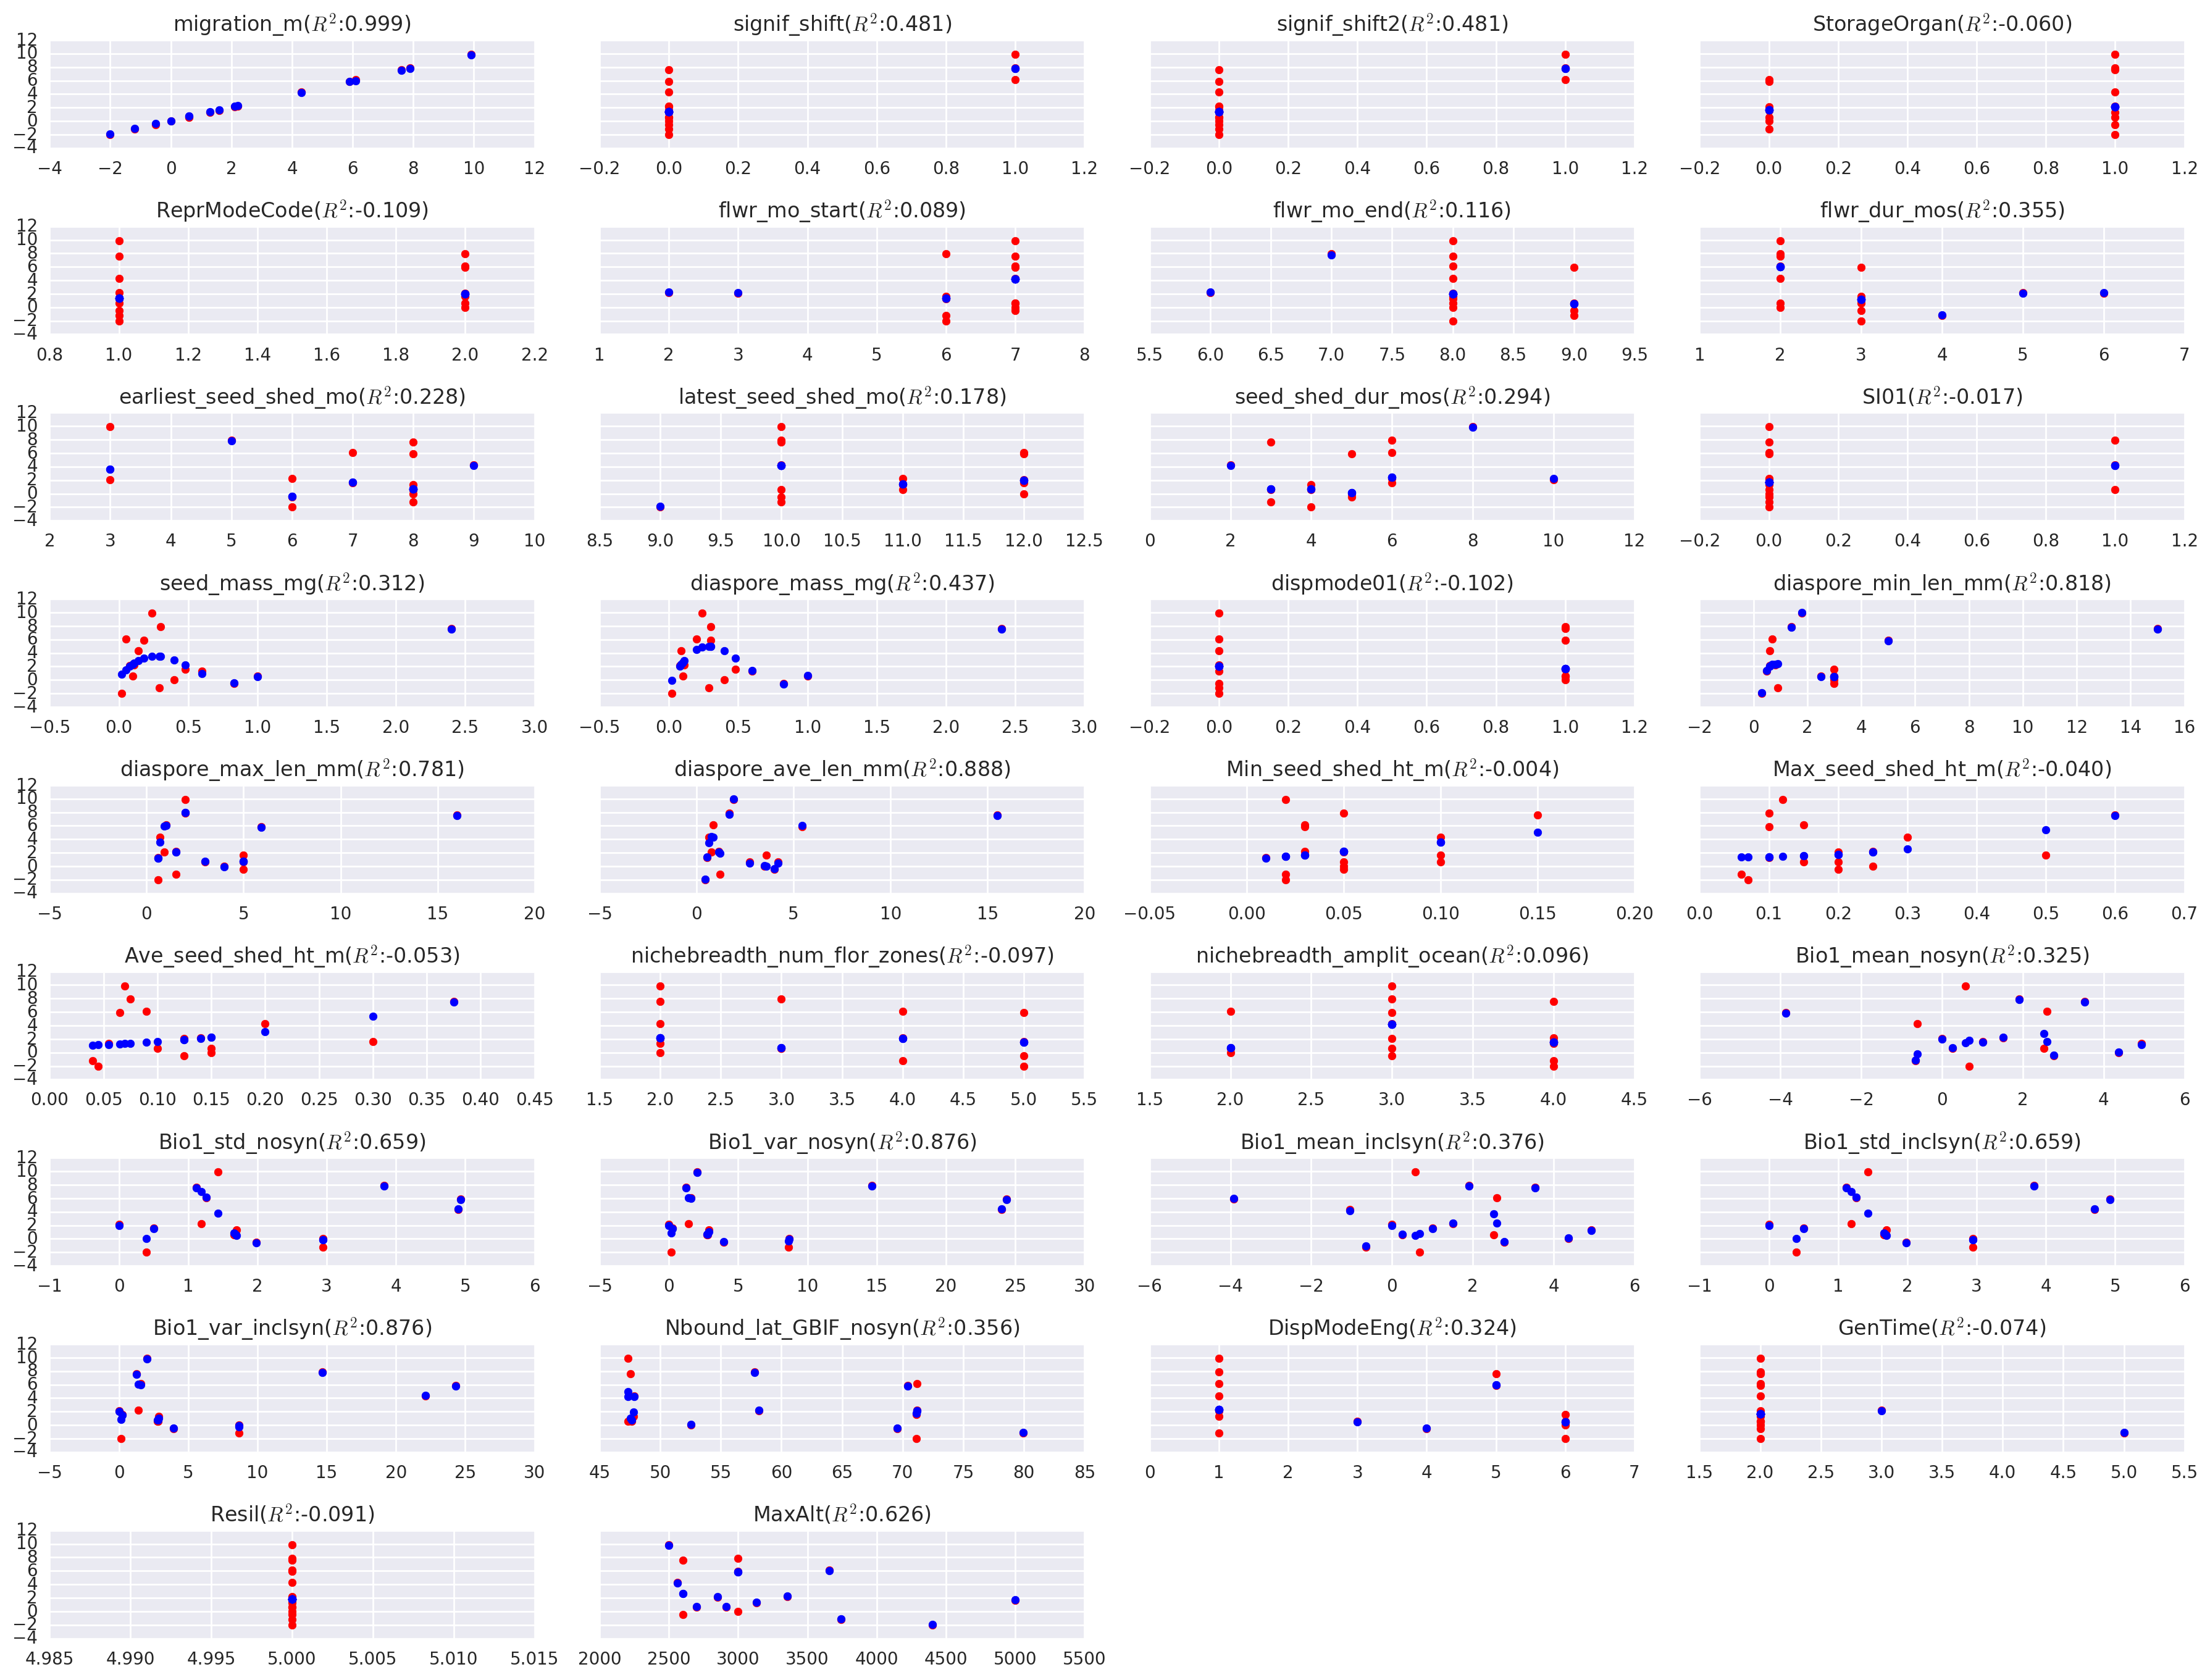

In [12]:
fig, subplots = plt.subplots(10, 4, sharey=True)
fig.set_figwidth(18)
fig.set_figheight(15)
featureIter = iter(list(test_features))


for row in range(0, 10):
    for col in range(0, 4):
        try:
            feat = next(featureIter)
            X = test_data[feat].values.reshape(-1,1)
            Y = test_data["migration_m"]
            model.fit(X, Y)
            predictions = model.predict(X)
            score = model.score(X, Y)
            subplots[row, col].scatter(X,  Y, color='red')
            subplots[row, col].scatter(X, predictions, color='blue')
            subplots[row, col].set_title(feat + "($R^2$:" + str("%.3f" % score) + ")")
            
    
        except StopIteration:
            fig.delaxes(subplots[row,col])
                    

plt.tight_layout()
plt.show()
        


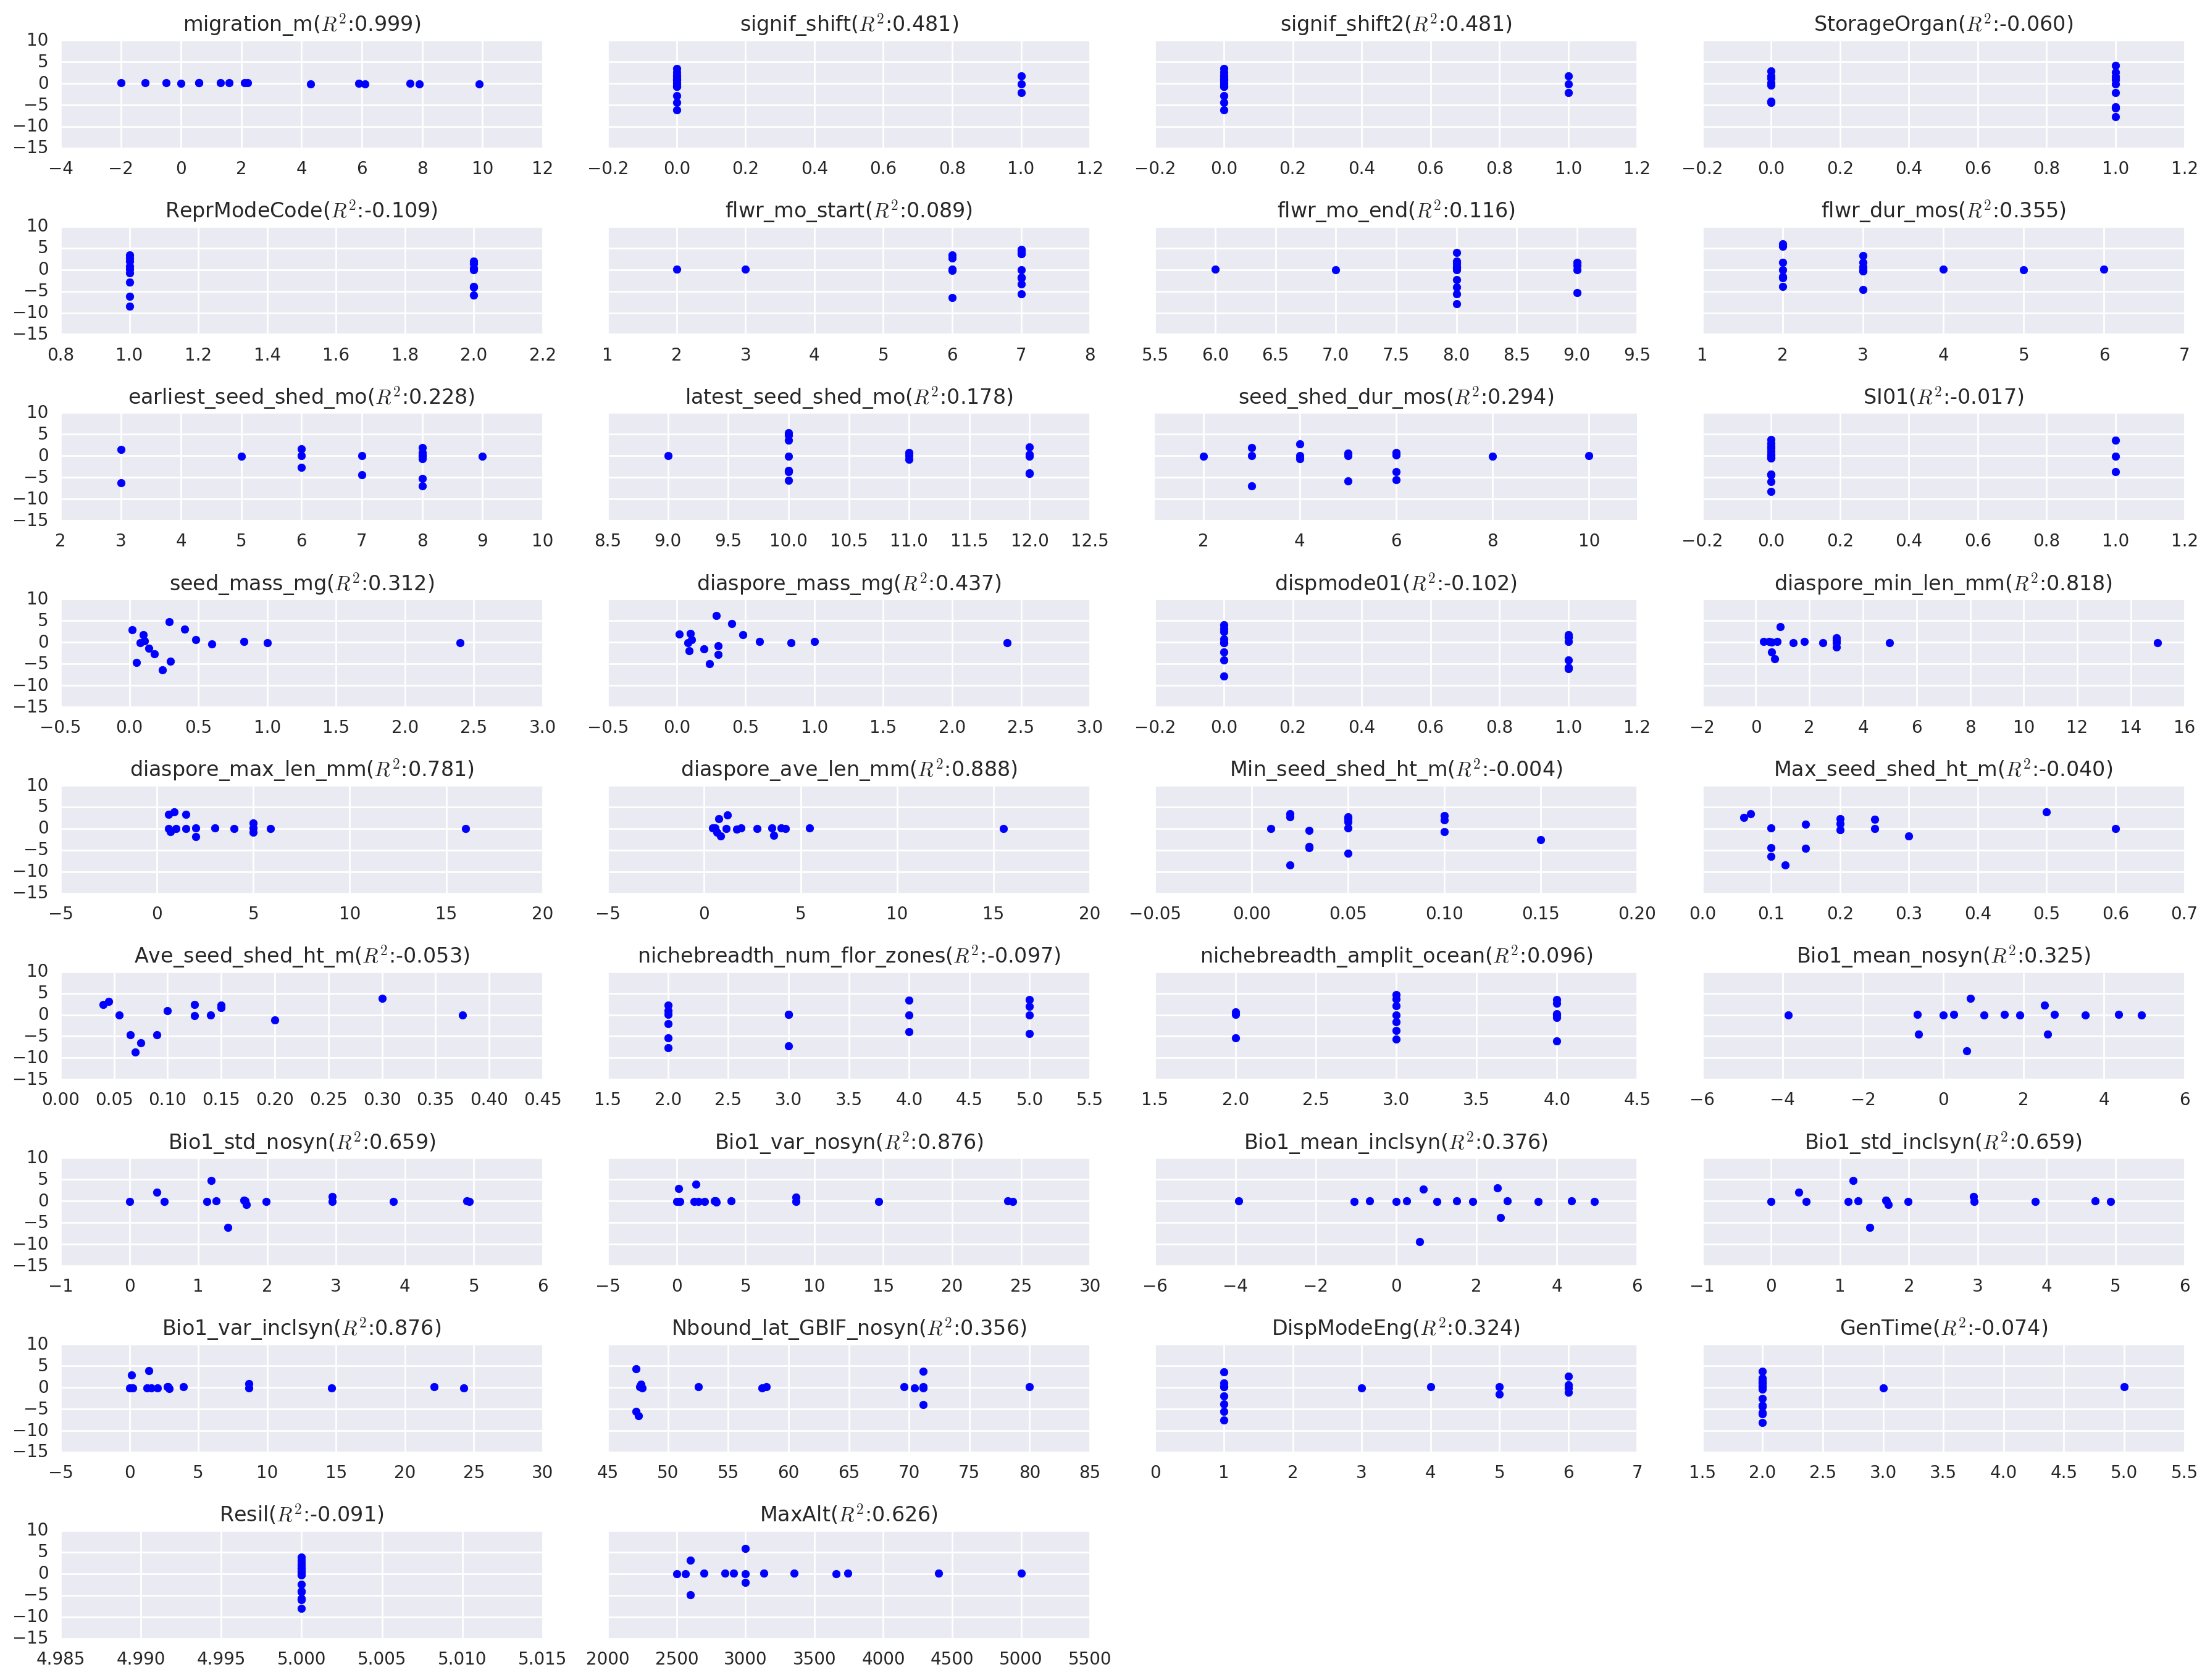

In [13]:
## RESIDUALS

fig, subplots = plt.subplots(10, 4, sharey=True)
fig.set_figwidth(18)
fig.set_figheight(15)
featureIter = iter(test_features)


for row in range(0, 10):
    for col in range(0, 4):
        try:
            feat = next(featureIter)
            X = test_data[feat].values.reshape(-1,1)
            Y = test_data["migration_m"]
            model.fit(X, Y)
            predictions = model.predict(X)
            score = model.score(X, Y)
            subplots[row, col].scatter(X, predictions-Y, color='blue')
            subplots[row, col].set_title(feat + "($R^2$:" + str("%.3f" % score) + ")")

        except StopIteration:
            fig.delaxes(subplots[row,col])
                    

plt.tight_layout()
plt.show()

# Stepping Back

I think an interesting excercise would be to figure out what the principal components of these data are and plot the explained variance––my intuition here is that there's only a couple interesting features. 

In [14]:
from sklearn.decomposition import PCA

pca_allcomponents = PCA() # select all components. We'll plot the eigenvalues. 
pca_somecomponents = PCA(n_components=0.95, svd_solver='full')
pca_allcomponents.fit(features)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
len(pca_allcomponents.components_)

20

In [16]:
pca_allcomponents.explained_variance_

array([  4.60162132e+05,   1.04176485e+02,   9.24525428e+01,
         3.16576052e+01,   5.77024782e+00,   5.50291678e+00,
         3.88945410e+00,   2.25368014e+00,   1.18643326e+00,
         7.52314860e-01,   5.09851031e-01,   4.15517264e-01,
         3.41659752e-01,   3.13243734e-01,   2.14137519e-01,
         1.58779652e-01,   8.30428648e-02,   4.80010427e-02,
         3.44250212e-02,   1.05799599e-28])

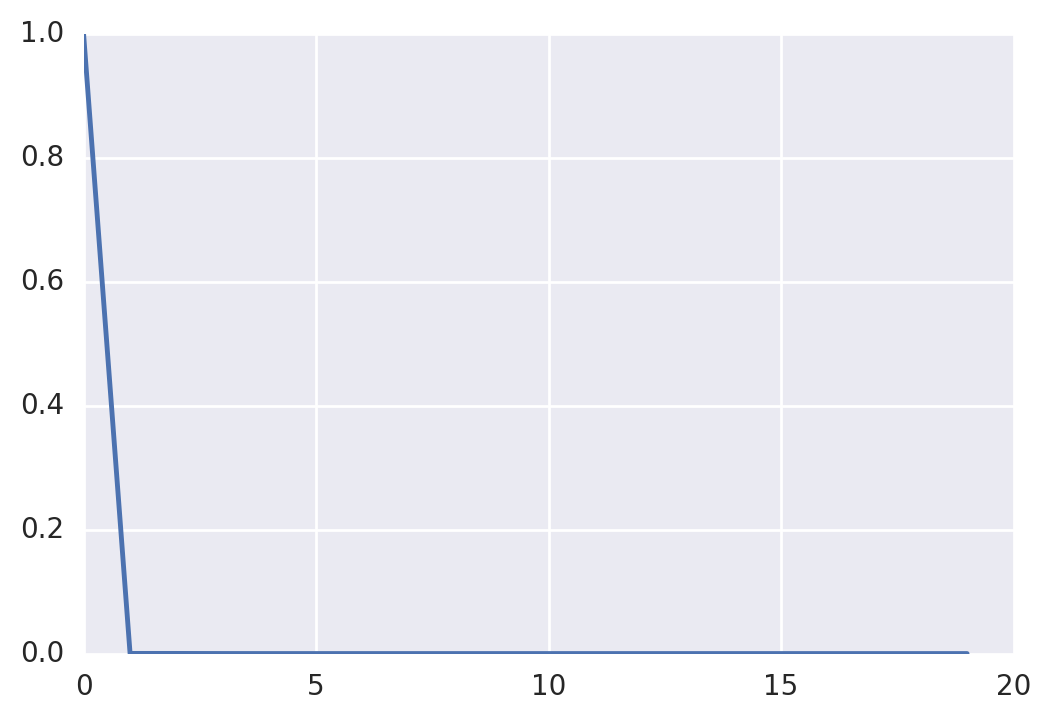

In [17]:
plt.plot(pca_allcomponents.explained_variance_ratio_)

Alright that didn't work very well. Perhaps we scale the data to normals?

In [18]:
from sklearn.preprocessing import StandardScaler, normalize

scaler = StandardScaler()

scaler.fit(features)
scaled = scaler.transform(features)

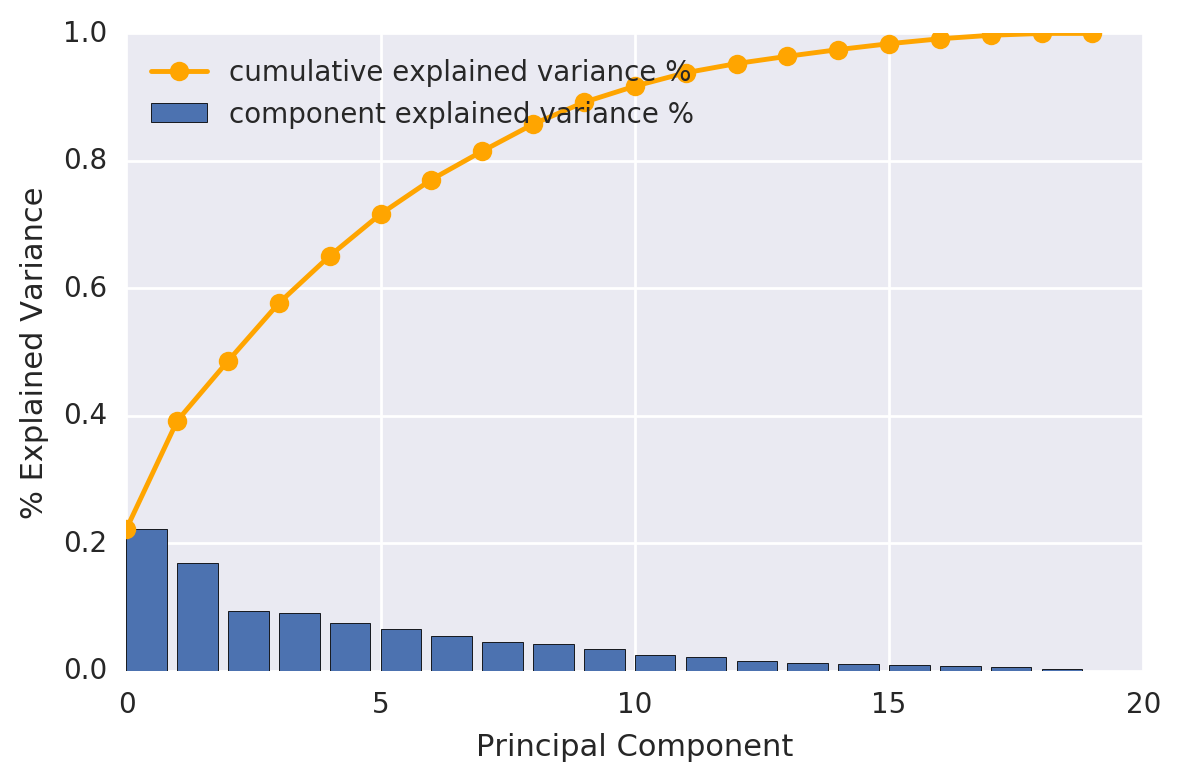

In [19]:

exp_var_all = pca_allcomponents.fit(scaled).explained_variance_ratio_
plt.bar(left=range(0, len(exp_var_all)), height=exp_var_all, label='component explained variance %')
plt.xlabel("Principal Component")
plt.ylabel("% Explained Variance")
plt.plot(np.cumsum(exp_var_all), '-o', color='orange', label="cumulative explained variance %")
plt.legend(loc='upper left')
plt.tight_layout()


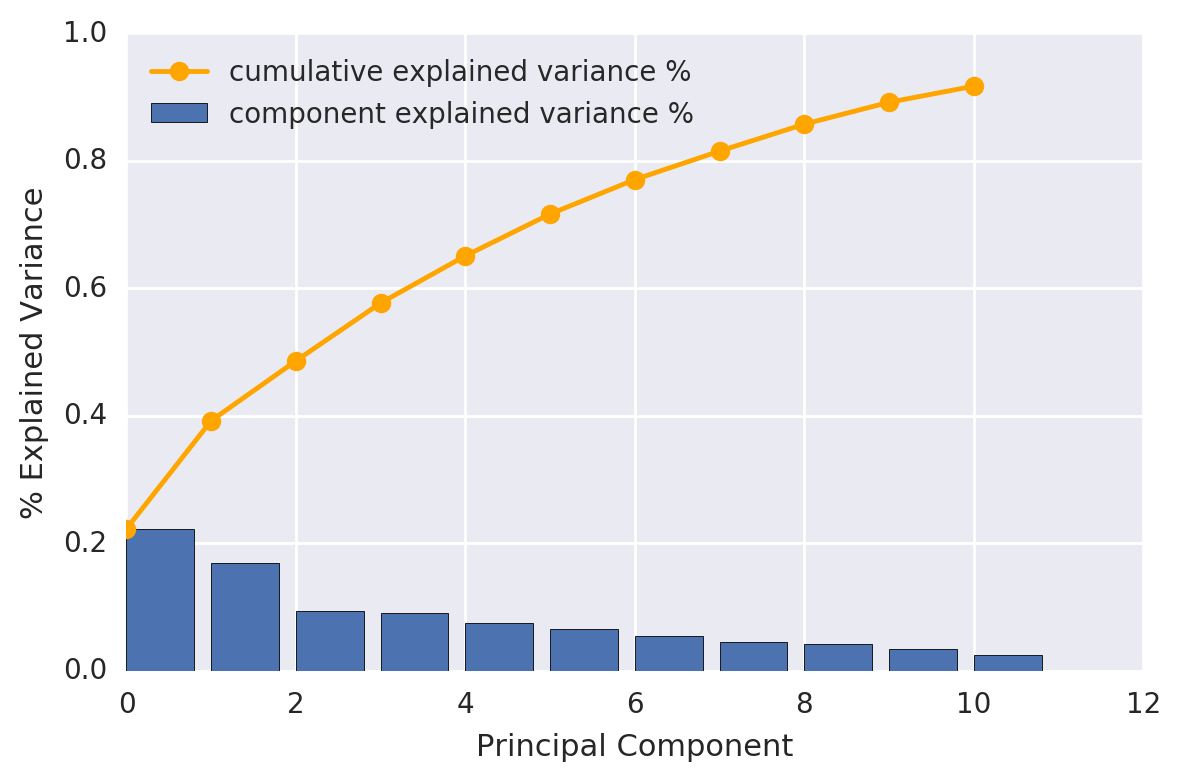

In [20]:
pca_somecomponents = PCA(n_components=0.90, svd_solver='full')

exp_var_some = pca_somecomponents.fit(scaled).explained_variance_ratio_
plt.bar(left=range(0, len(exp_var_some)), height=exp_var_some, label='component explained variance %')
plt.plot(np.cumsum(exp_var_some), '-o', color='orange', label="cumulative explained variance %")
plt.legend(loc='upper left')
plt.xlabel("Principal Component")
plt.ylabel("% Explained Variance")
plt.tight_layout()

Take a look at feature correlations, shall we. 

In [21]:
coefs = pd.DataFrame(pca_allcomponents.components_.T, columns = ["PC:"+str(x) for x in range(0, len(pca_allcomponents.components_))], index=features.columns)

In [22]:
list(zip(coefs.columns, coefs.abs()[:].idxmax(),coefs.abs()[:].max(), coefs[:].abs().mean()))

[('PC:0', 'seed_mass_mg', 0.29184135633528335, 0.10699329844548025),
 ('PC:1', 'Bio1_var_nosyn', 0.26770442773175335, 0.11638708449424109),
 ('PC:2', 'StorageOrgan', 0.3440951030624686, 0.11174874254160316),
 ('PC:3', 'Nbound_lat_GBIF_nosyn', 0.2890995579790519, 0.11185454701641008),
 ('PC:4', 'BreedSysCode_1.0', 0.35358158883607049, 0.10144552871985556),
 ('PC:5', 'latest_seed_shed_mo', 0.369163937593047, 0.1052887945776355),
 ('PC:6', 'earliest_seed_shed_mo', 0.3232017773938165, 0.10693871148615502),
 ('PC:7', 'dispersal_mode_wind', 0.41107923907037724, 0.10802259616478362),
 ('PC:8', 'dispersal_mode_animal', 0.34859725950261411, 0.1124938883447501),
 ('PC:9', 'BreedSysCode_3.0', 0.4242939237149197, 0.10097905838891191),
 ('PC:10', 'flwr_mo_start', 0.27464877237468266, 0.11934841016067856),
 ('PC:11', 'GenTime', 0.37360656883809668, 0.11116637171468968),
 ('PC:12', 'earliest_seed_shed_mo', 0.40119470680850317, 0.098832233138577211),
 ('PC:13', 'oceanity_so', 0.34056739783464368, 0.10

Note: the `components_` variable is defined as 
> Principal axes in feature space, representing the directions of maximum variance in the data.

which means that for each component, the value of each feature is the slope (**??**) of the component's vector for that feature.

Given this, **shouldn't we be scaling the data anyway?**



## Random forest regressions on scaled data <small>seems like a good idea given PCA</small>

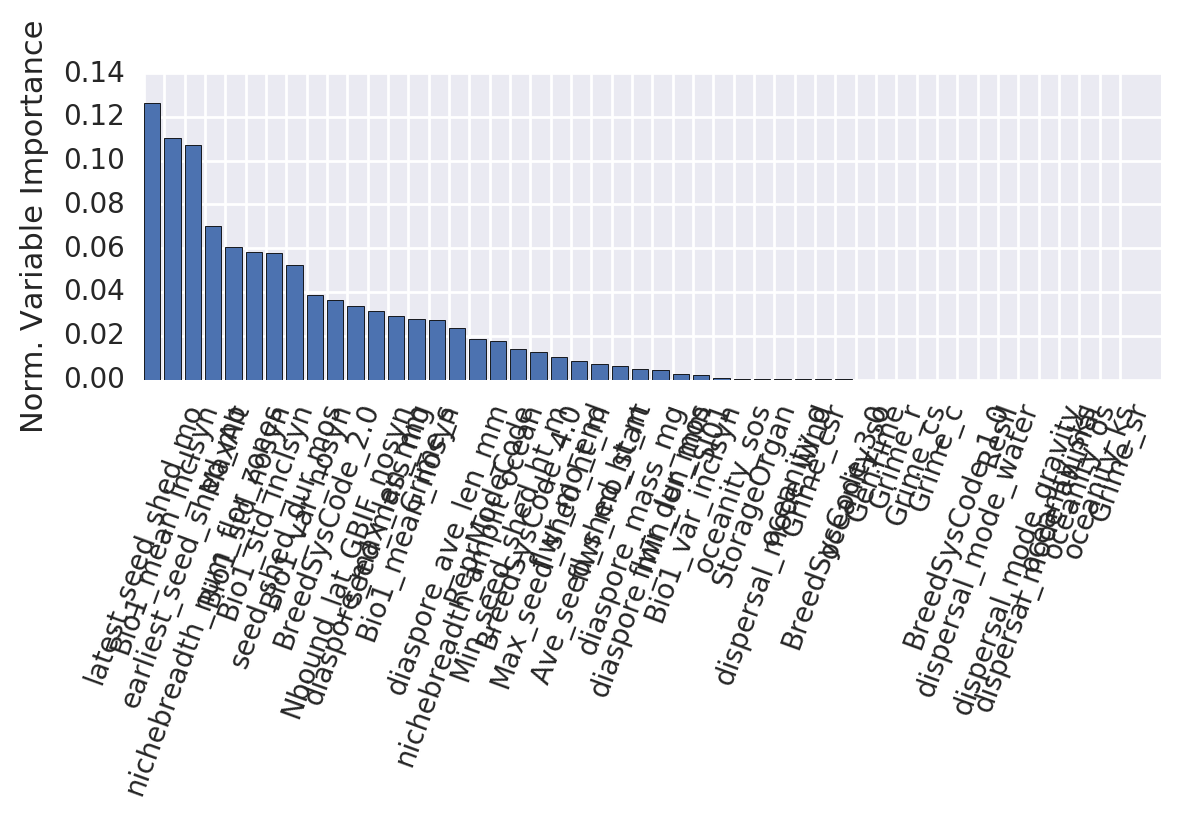

[('latest_seed_shed_mo', 0.12614118688317227),
 ('Bio1_mean_inclsyn', 0.11031625756950805),
 ('earliest_seed_shed_mo', 0.10699023562276155),
 ('nichebreadth_num_flor_zones', 0.070102367517729552),
 ('MaxAlt', 0.060339663790348066),
 ('Bio1_std_nosyn', 0.058232540871362683),
 ('Bio1_std_inclsyn', 0.057785304315328745),
 ('seed_shed_dur_mos', 0.052323215387171308),
 ('Bio1_var_nosyn', 0.038637218590685703),
 ('BreedSysCode_2.0', 0.036472929655002435),
 ('Nbound_lat_GBIF_nosyn', 0.033388844982142611),
 ('diaspore_max_len_mm', 0.031350725183142018),
 ('seed_mass_mg', 0.029067241197917947),
 ('Bio1_mean_nosyn', 0.02759655428332387),
 ('Grime_s', 0.027256126033771914),
 ('diaspore_ave_len_mm', 0.023622025849727803),
 ('nichebreadth_amplit_ocean', 0.018490379523113783),
 ('ReprModeCode', 0.017812410197568275),
 ('Min_seed_shed_ht_m', 0.013979331486745458),
 ('BreedSysCode_4.0', 0.012739391752544007),
 ('Max_seed_shed_ht_m', 0.010202863594495412),
 ('flwr_mo_end', 0.0084586741810797113),
 ('Av

In [23]:
model = RandomForestRegressor()

X = features
Y = target

scaler.fit_transform(X)

model.fit(X, Y)

model.score(X, Y)

plot_importances(model.feature_importances_, X
                )


plt.show()
importances(model.feature_importances_, X)


## Are the data normal?


In [26]:
from scipy.stats import norm, kstest

for feature in features.columns.values:
    print(feature, kstest(features[feature], 'norm'))

StorageOrgan KstestResult(statistic=0.5, pvalue=3.7875952405341806e-05)
ReprModeCode KstestResult(statistic=0.84134474606854293, pvalue=2.2204460492503131e-16)
flwr_mo_start KstestResult(statistic=0.97724986805182079, pvalue=0.0)
flwr_mo_end KstestResult(statistic=0.9999999990134123, pvalue=0.0)
flwr_dur_mos KstestResult(statistic=0.97724986805182079, pvalue=0.0)
earliest_seed_shed_mo KstestResult(statistic=0.9986501019683699, pvalue=0.0)
latest_seed_shed_mo KstestResult(statistic=0.9986501019683699, pvalue=0.0)
seed_shed_dur_mos KstestResult(statistic=0.97724986805182079, pvalue=0.0)
SI01 KstestResult(statistic=0.5, pvalue=3.7875952405341806e-05)
seed_mass_mg KstestResult(statistic=0.50797831371690194, pvalue=2.6177487979506253e-05)
diaspore_mass_mg KstestResult(statistic=0.50797831371690194, pvalue=2.6177487979506253e-05)
diaspore_min_len_mm KstestResult(statistic=0.64146246127401307, pvalue=1.5437556344366499e-08)
diaspore_max_len_mm KstestResult(statistic=0.72574688224992645, pvalu

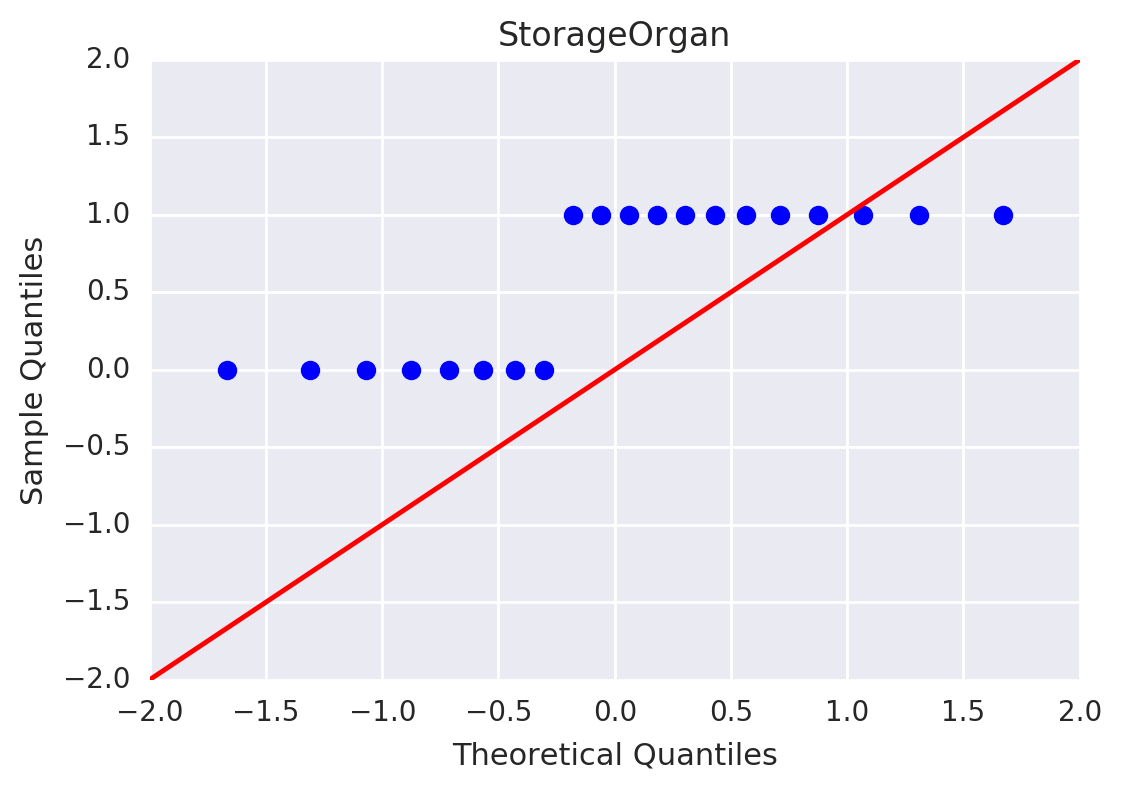

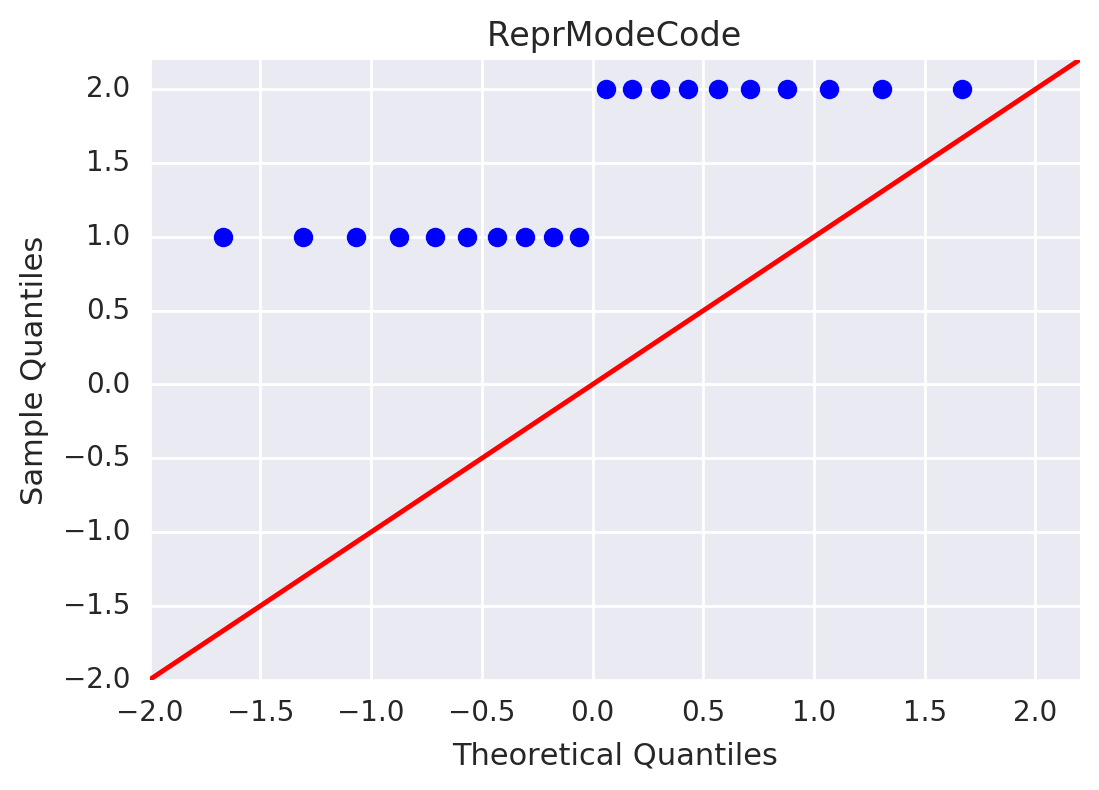

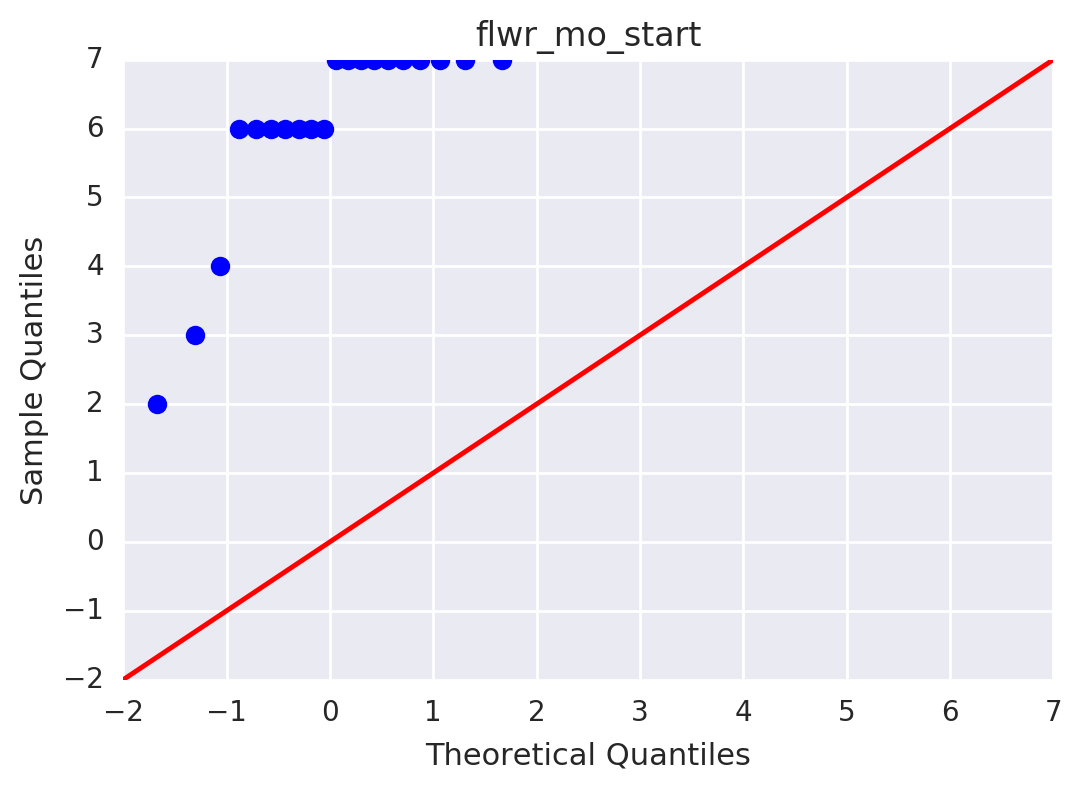

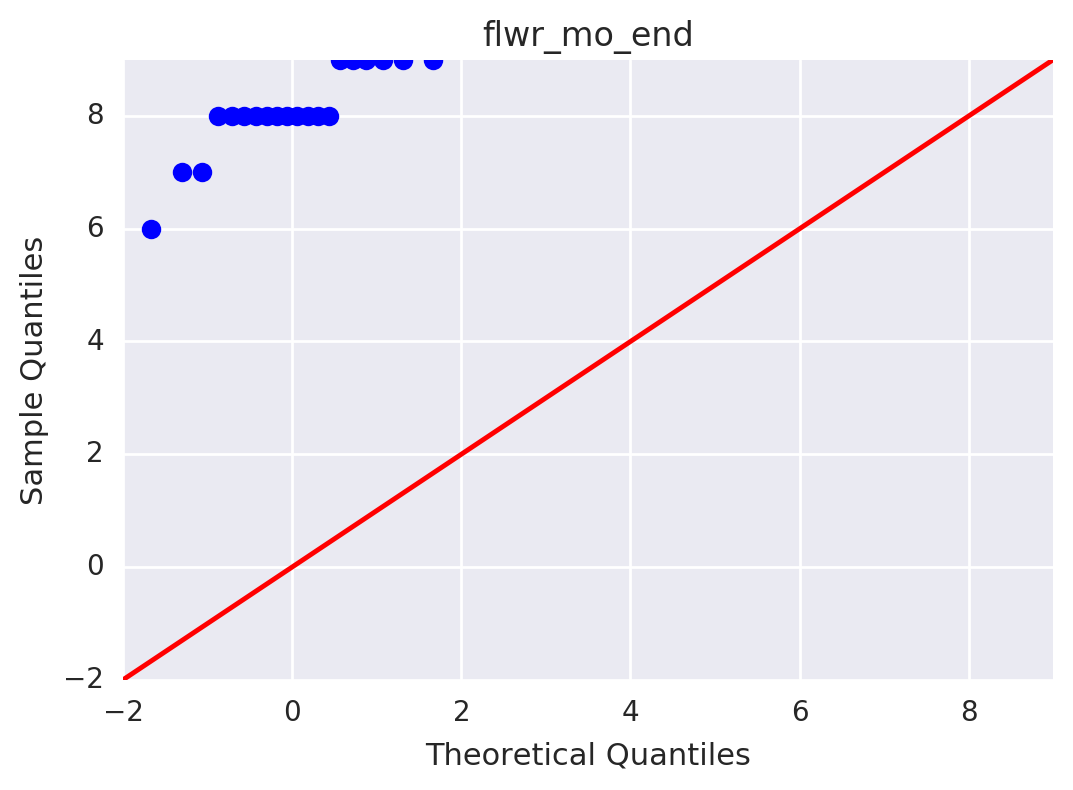

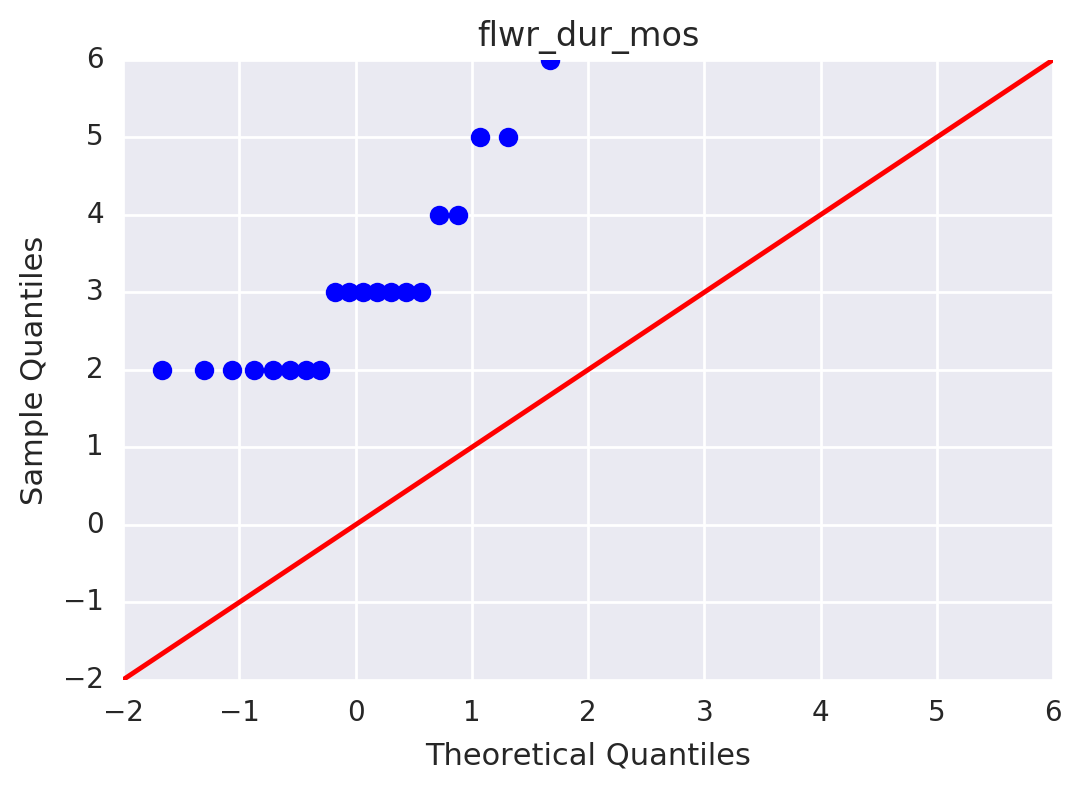

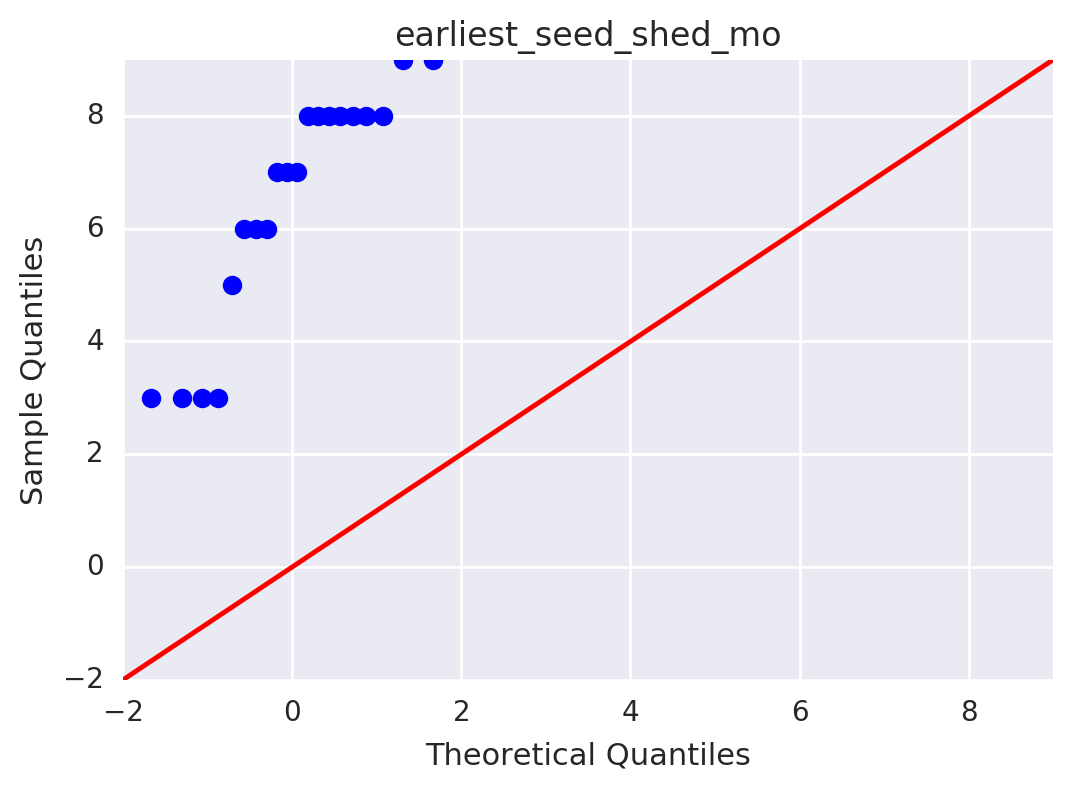

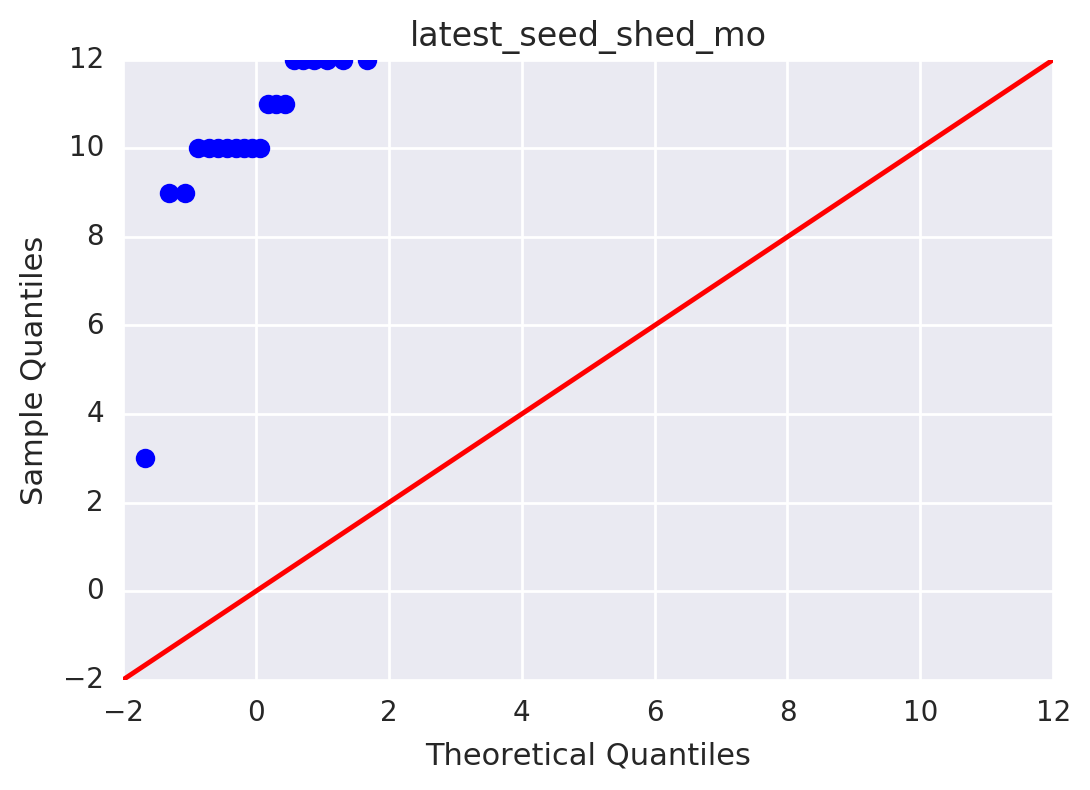

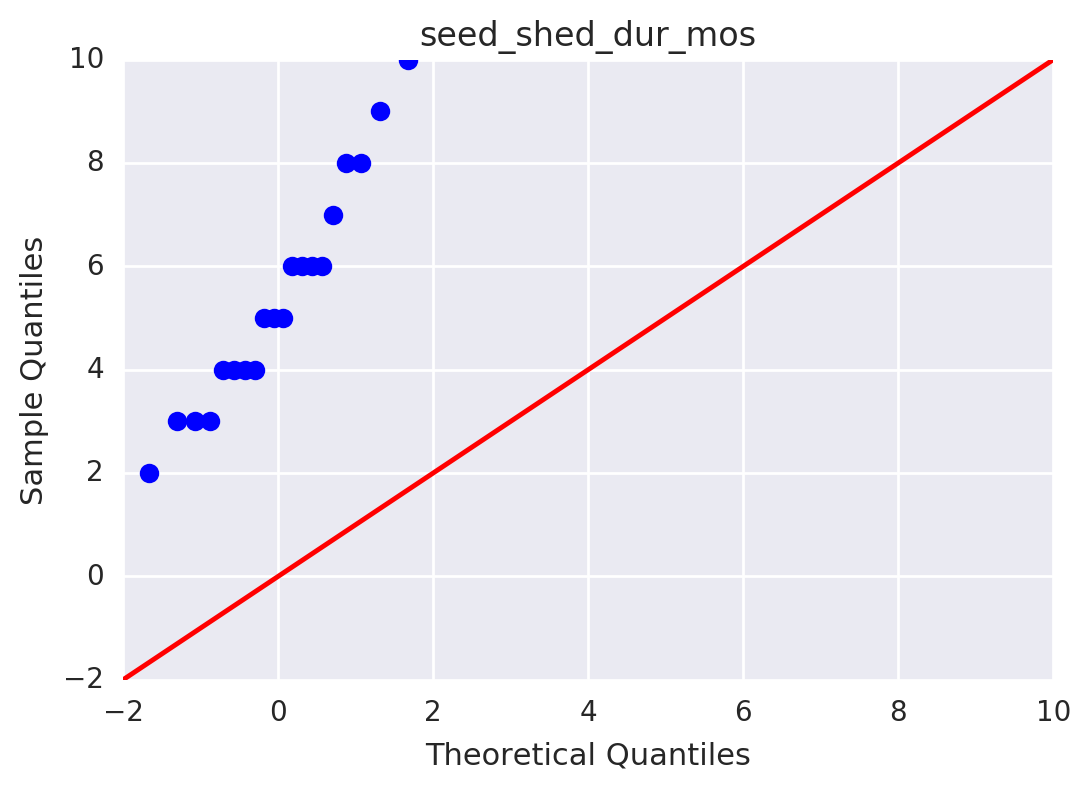

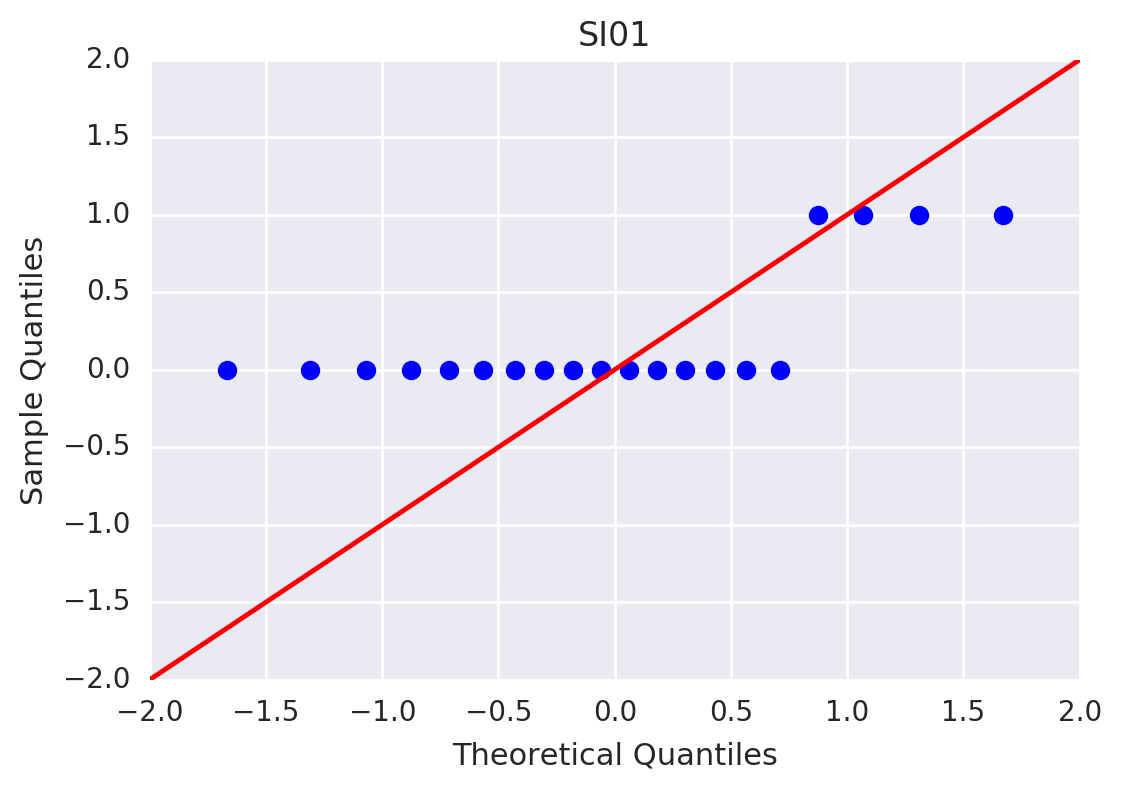

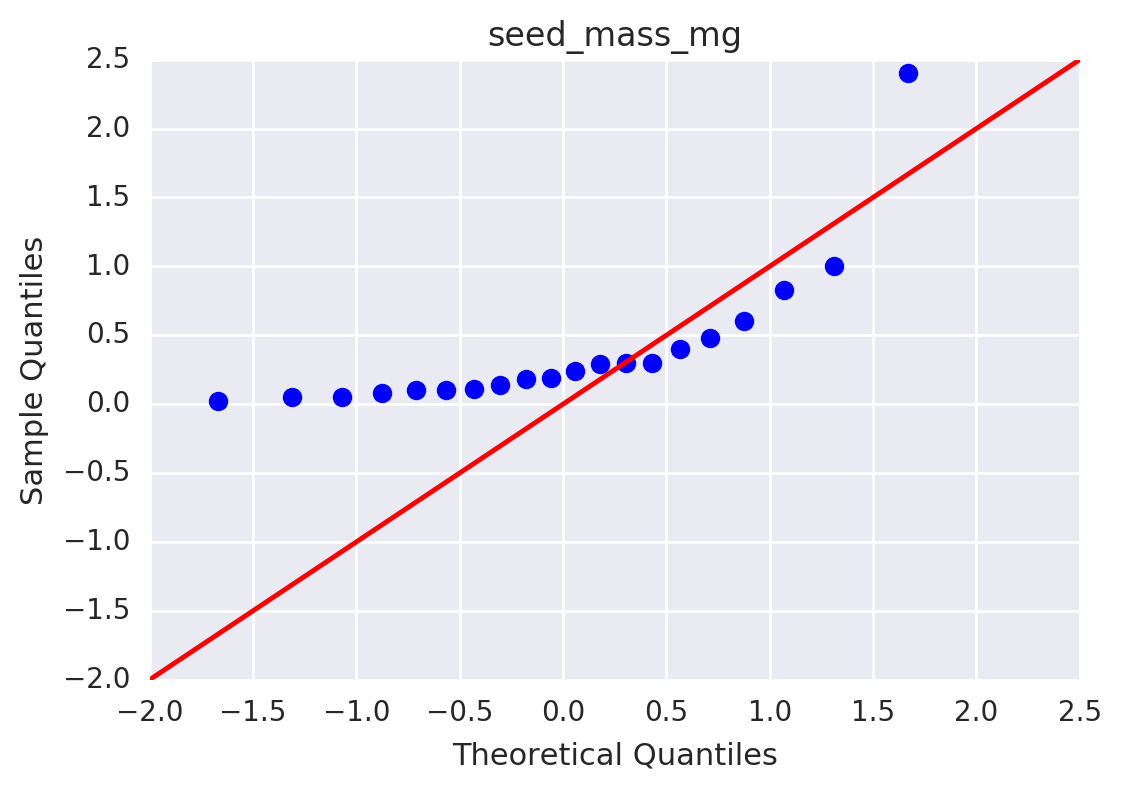

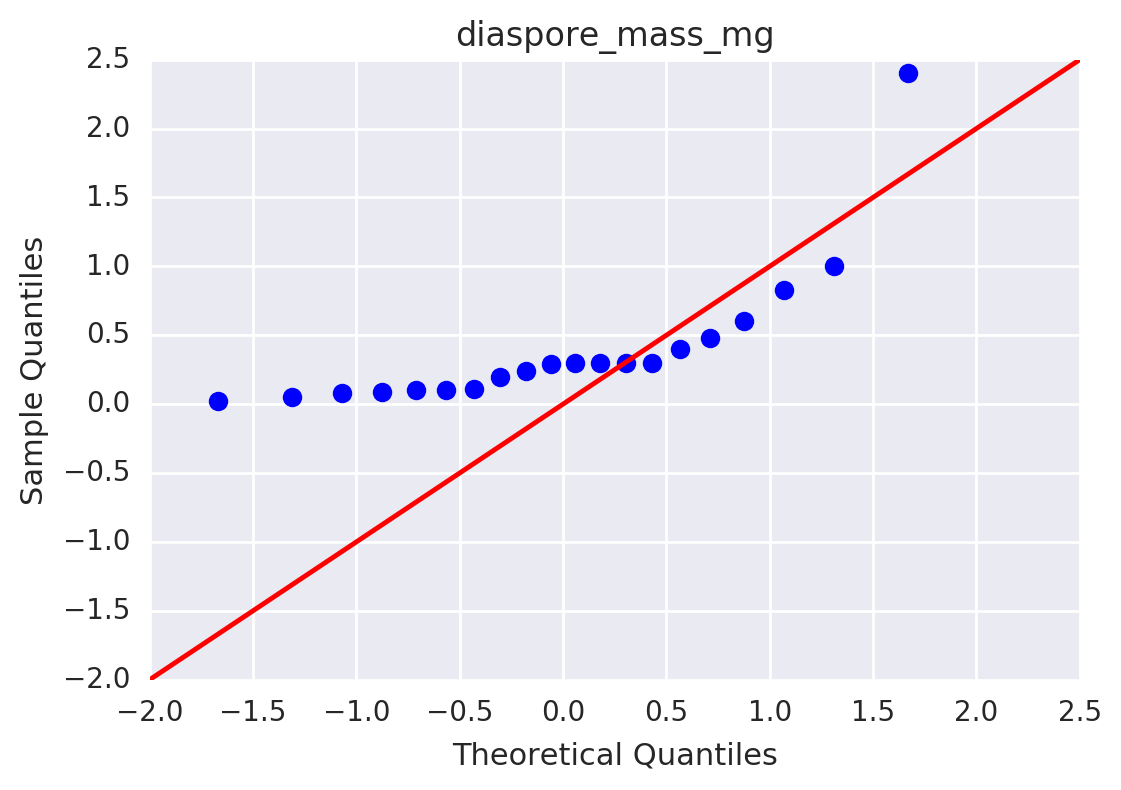

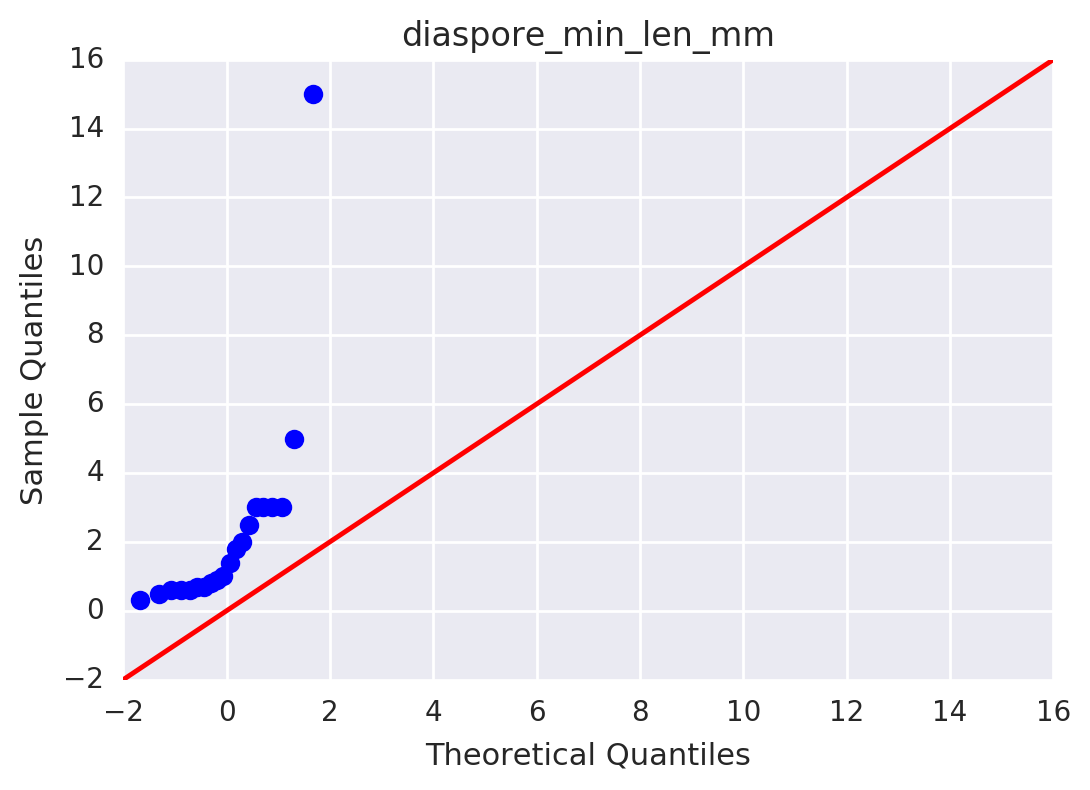

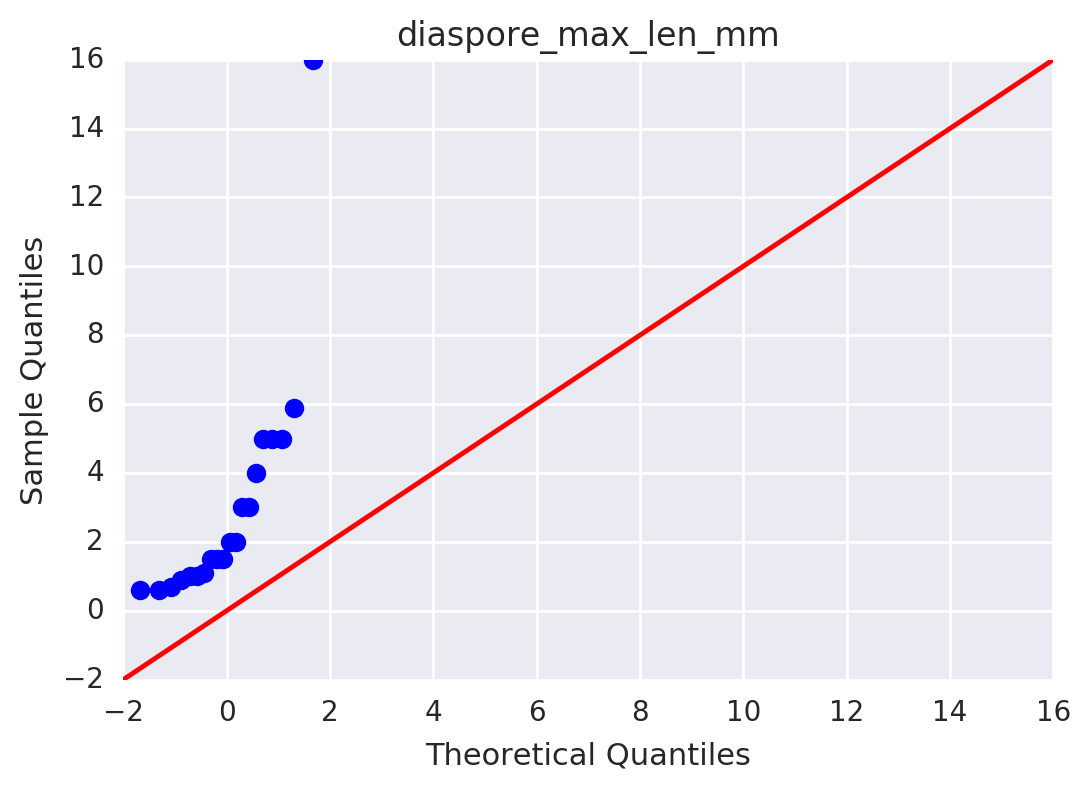

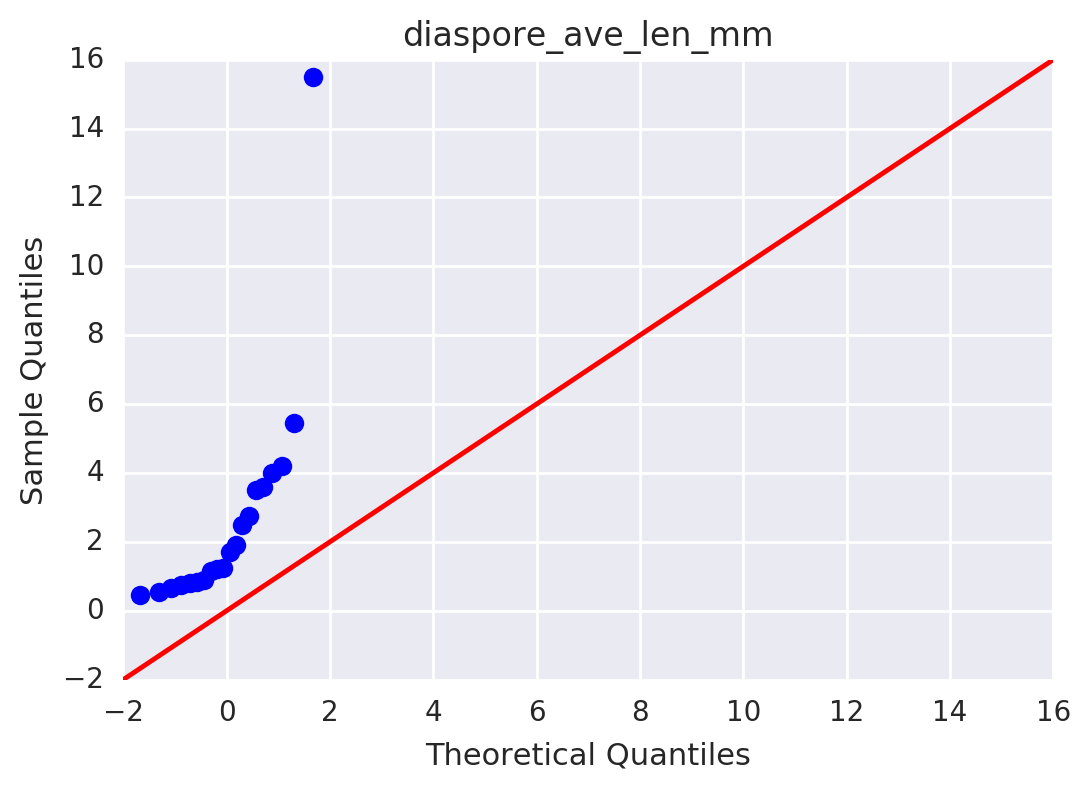

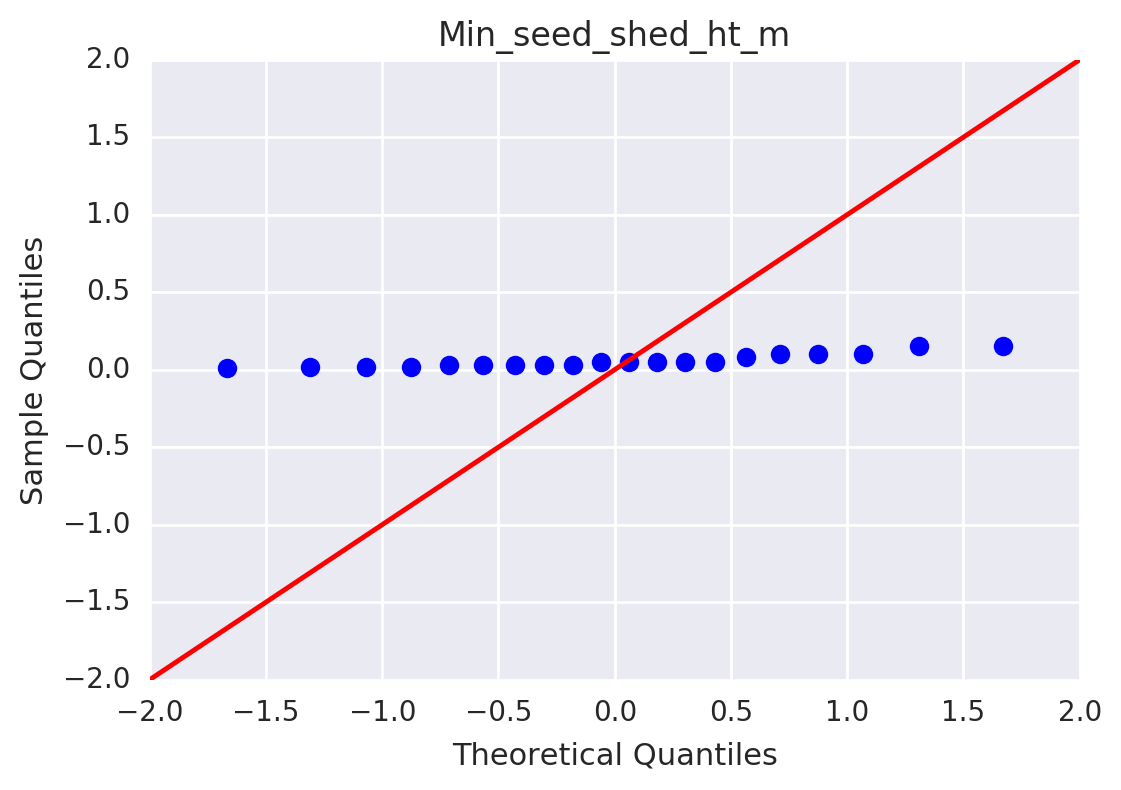

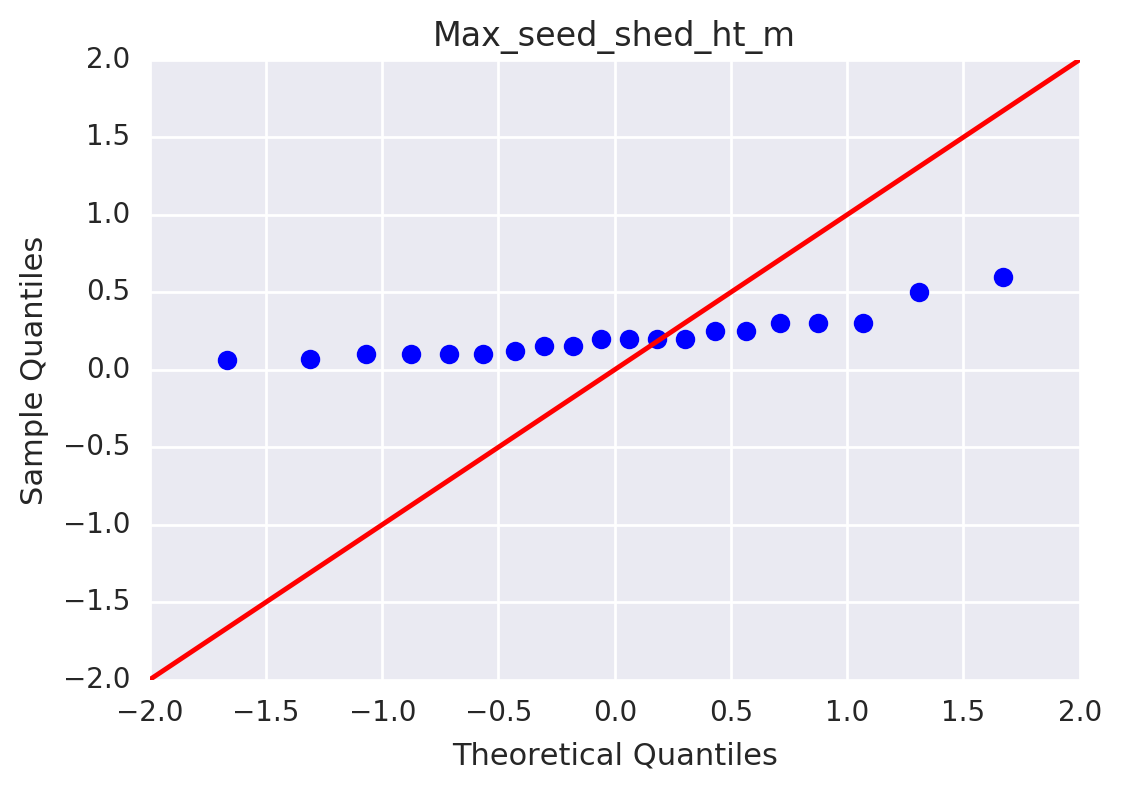

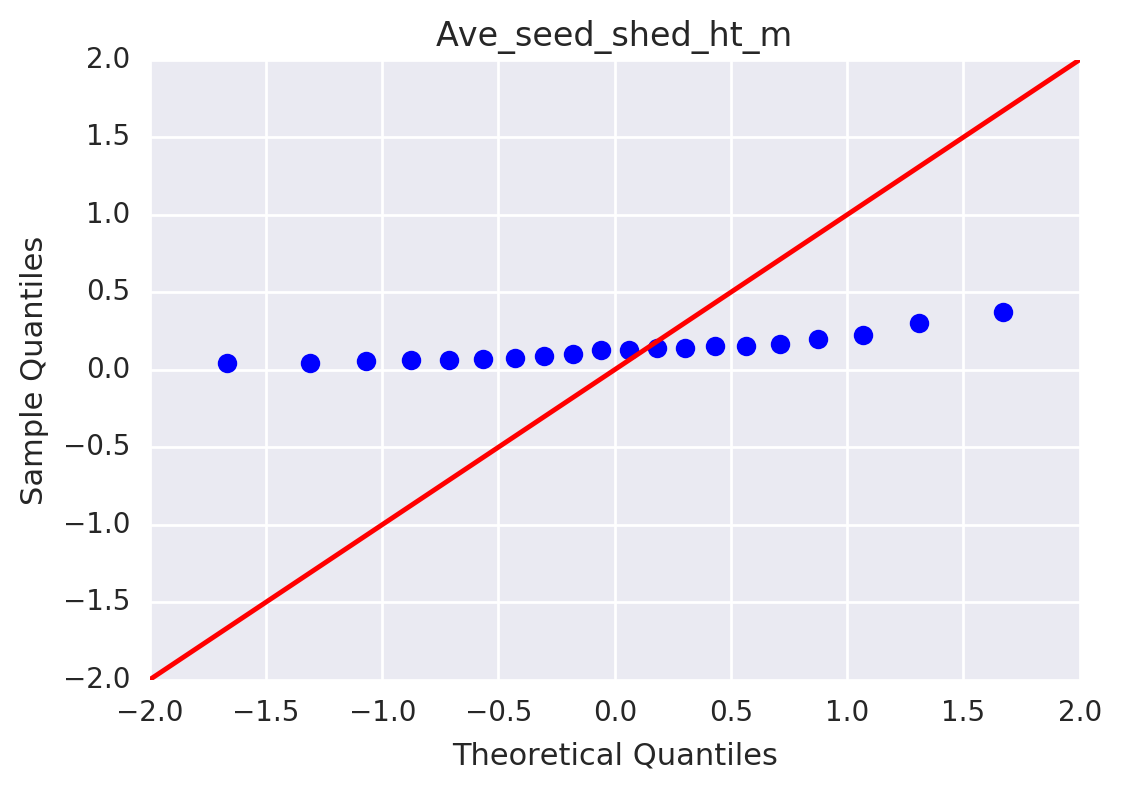

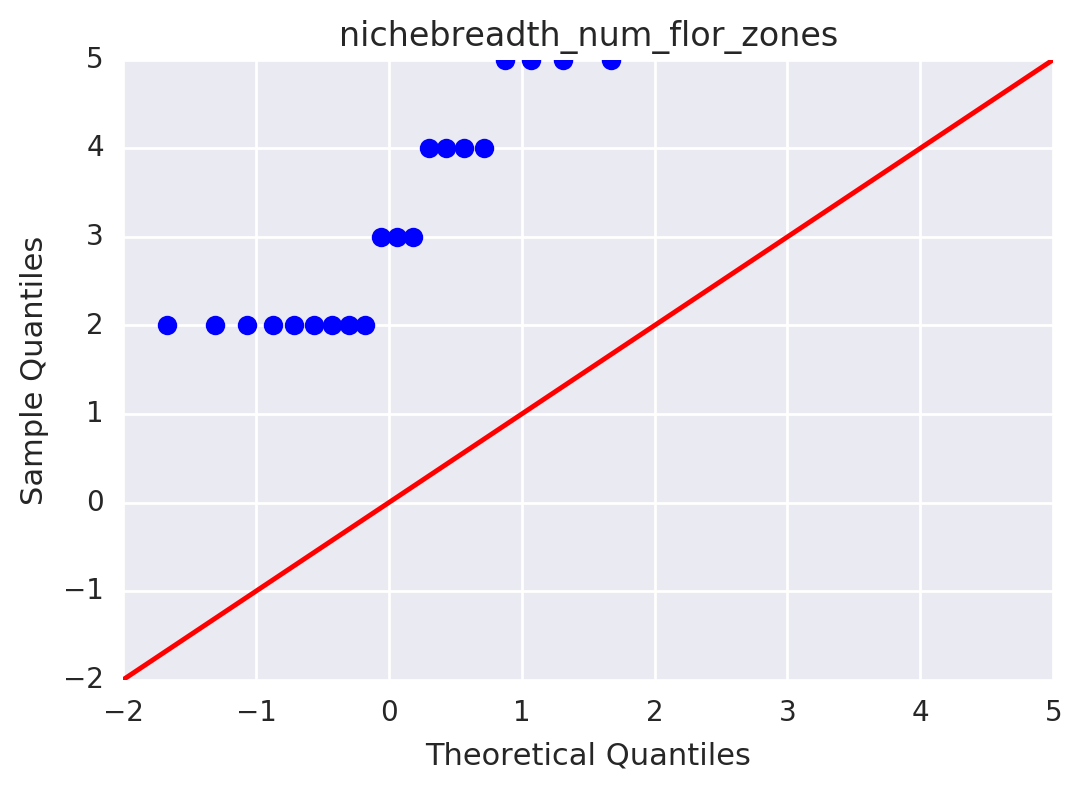

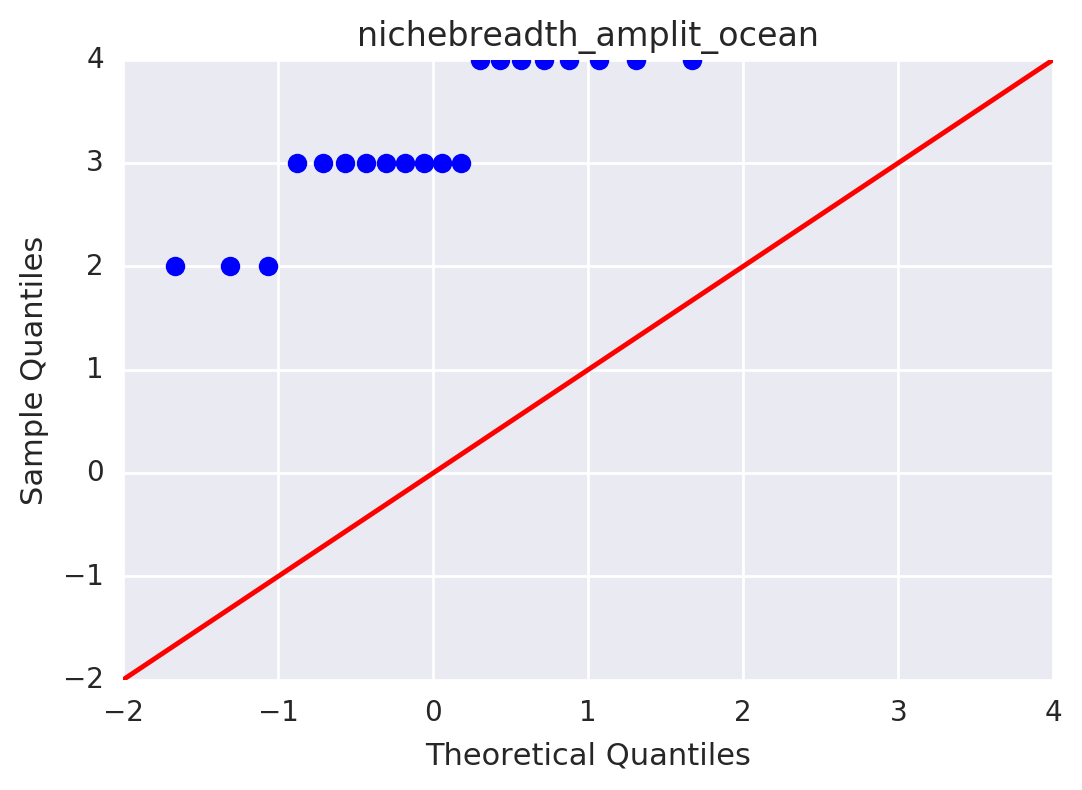

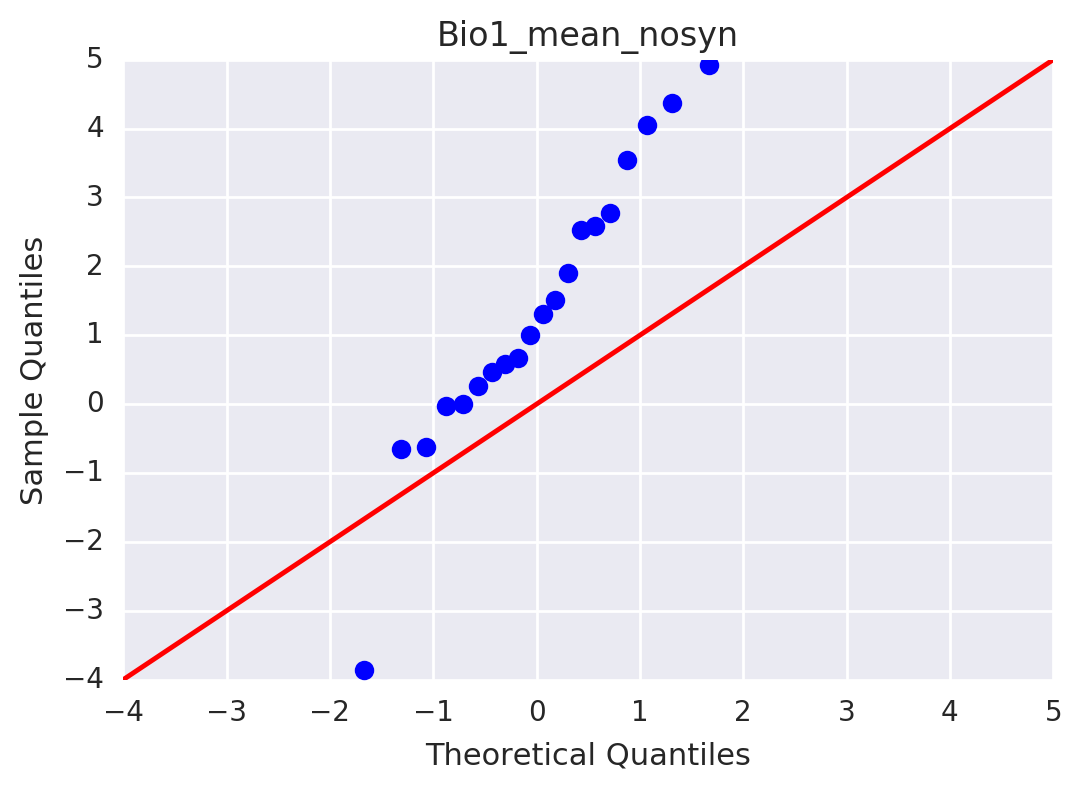

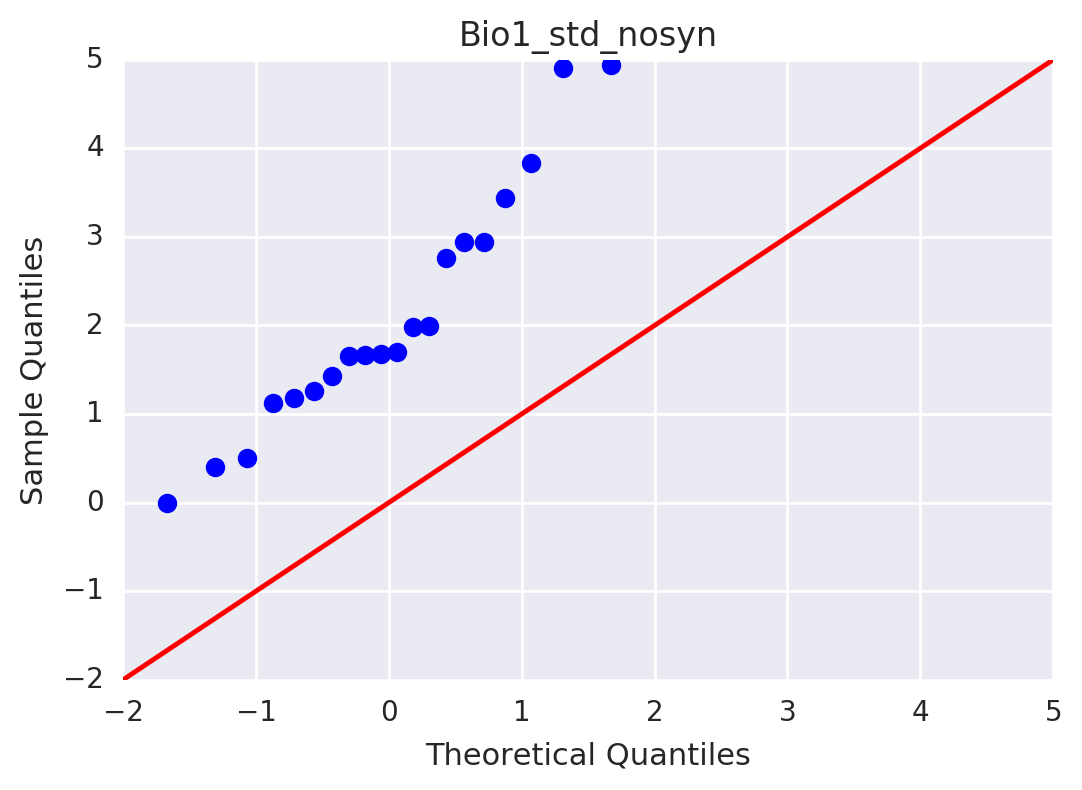

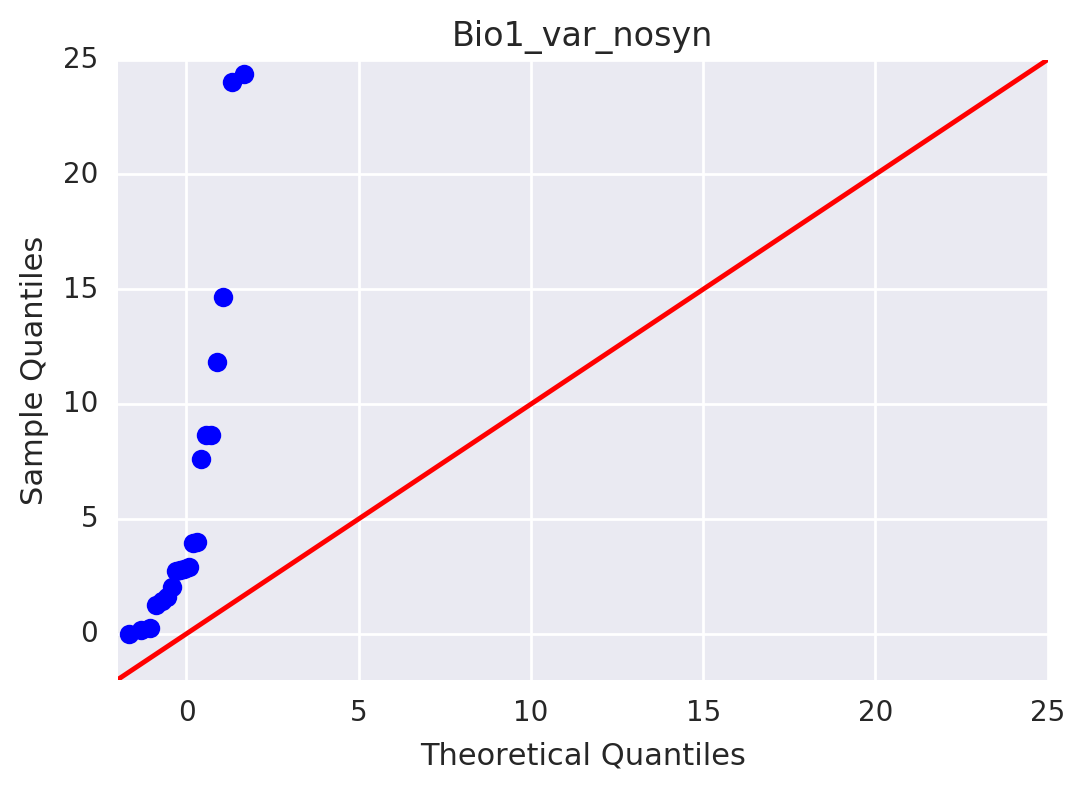

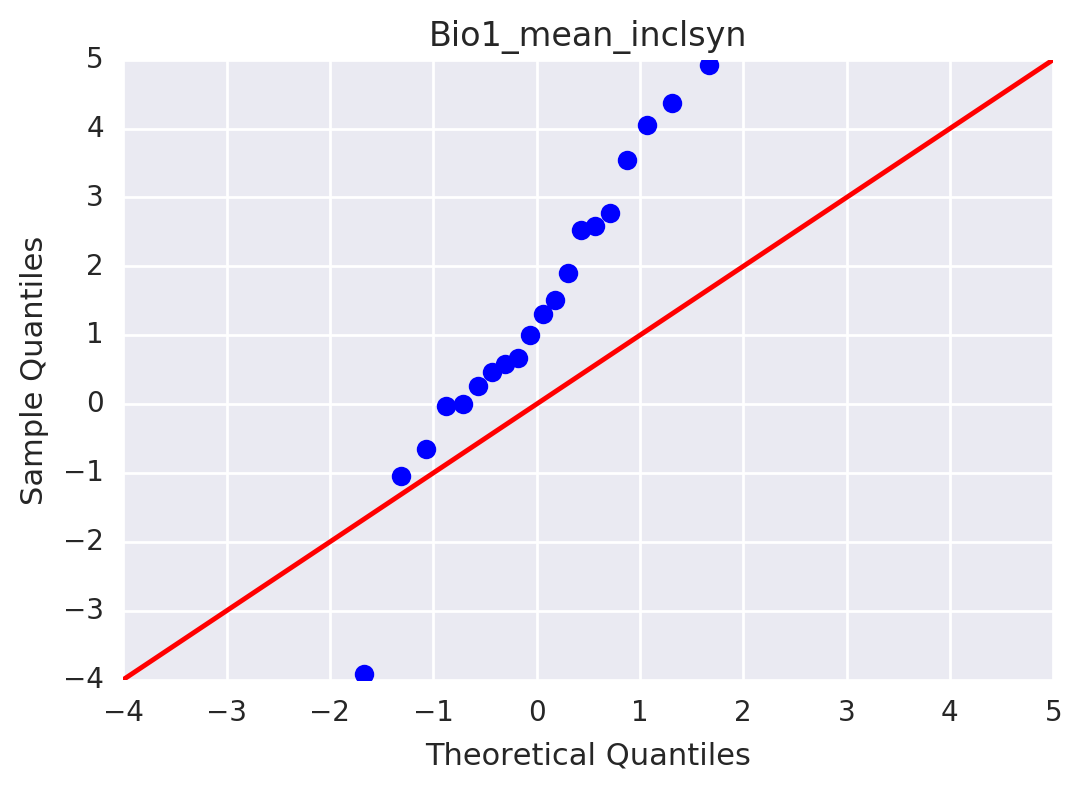

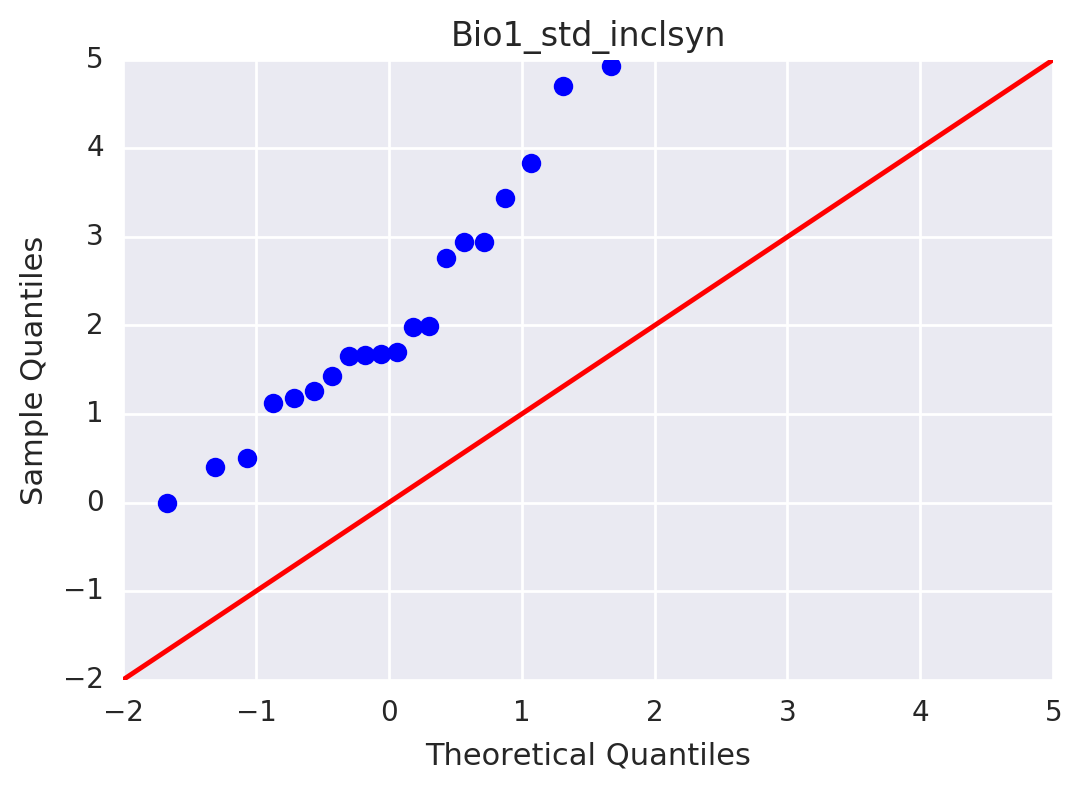

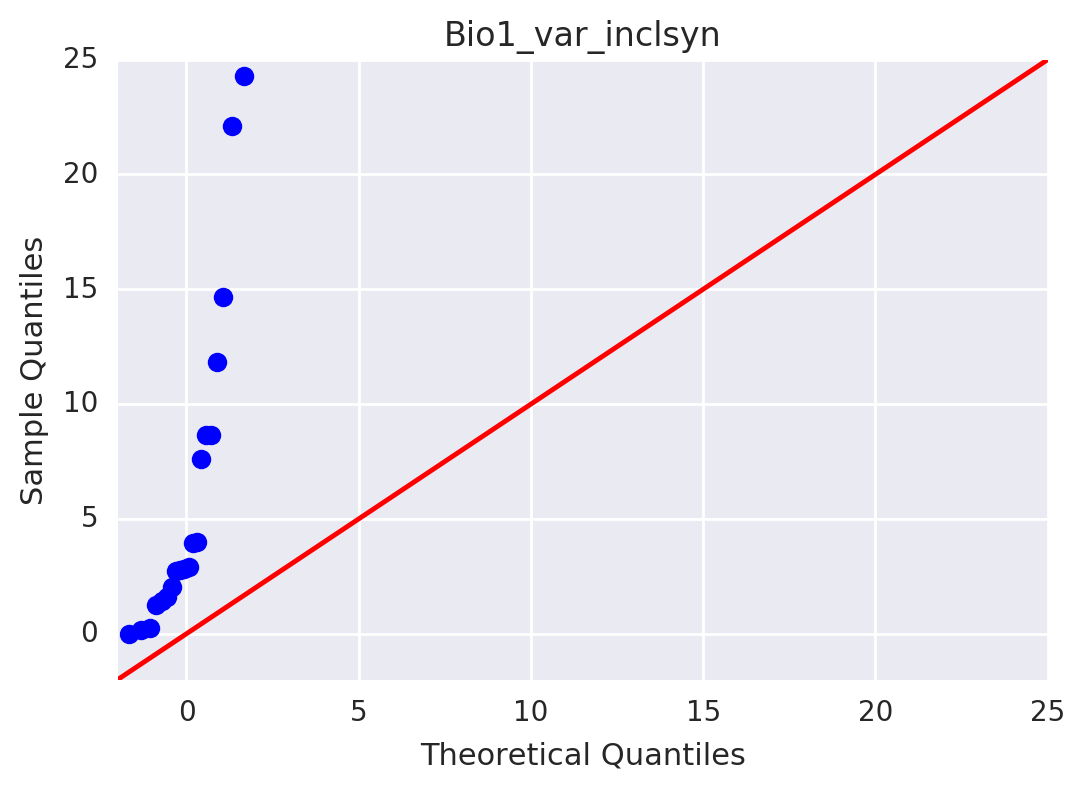

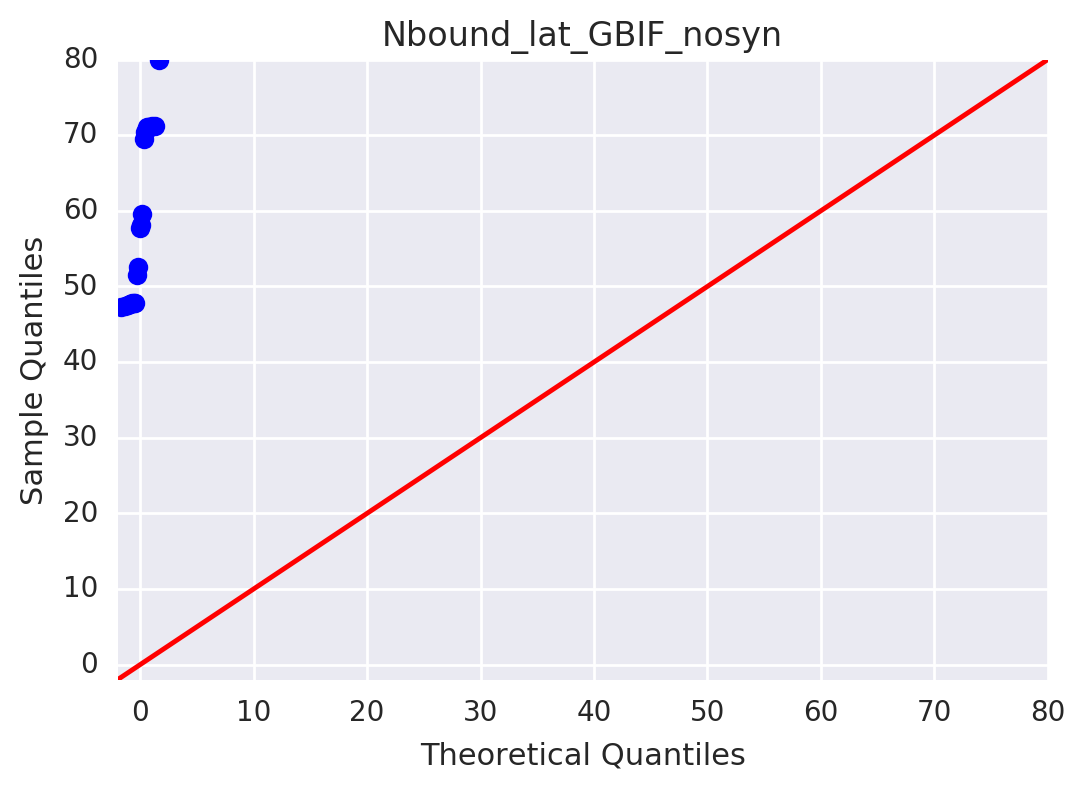

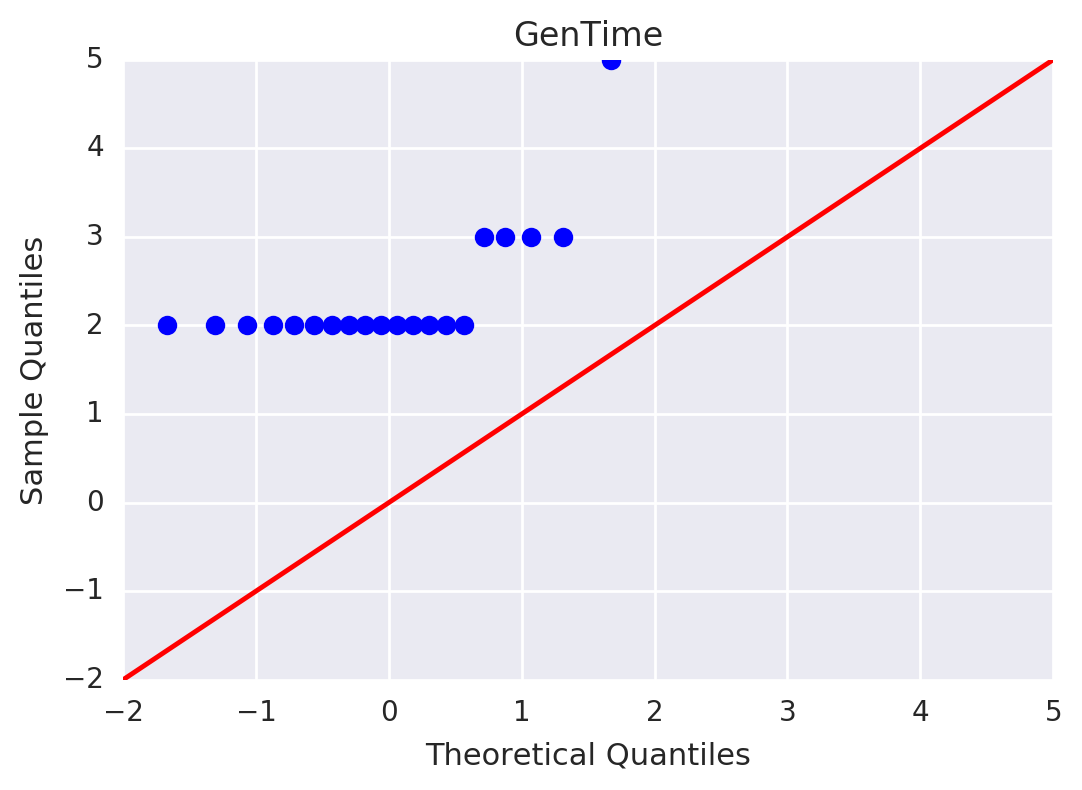

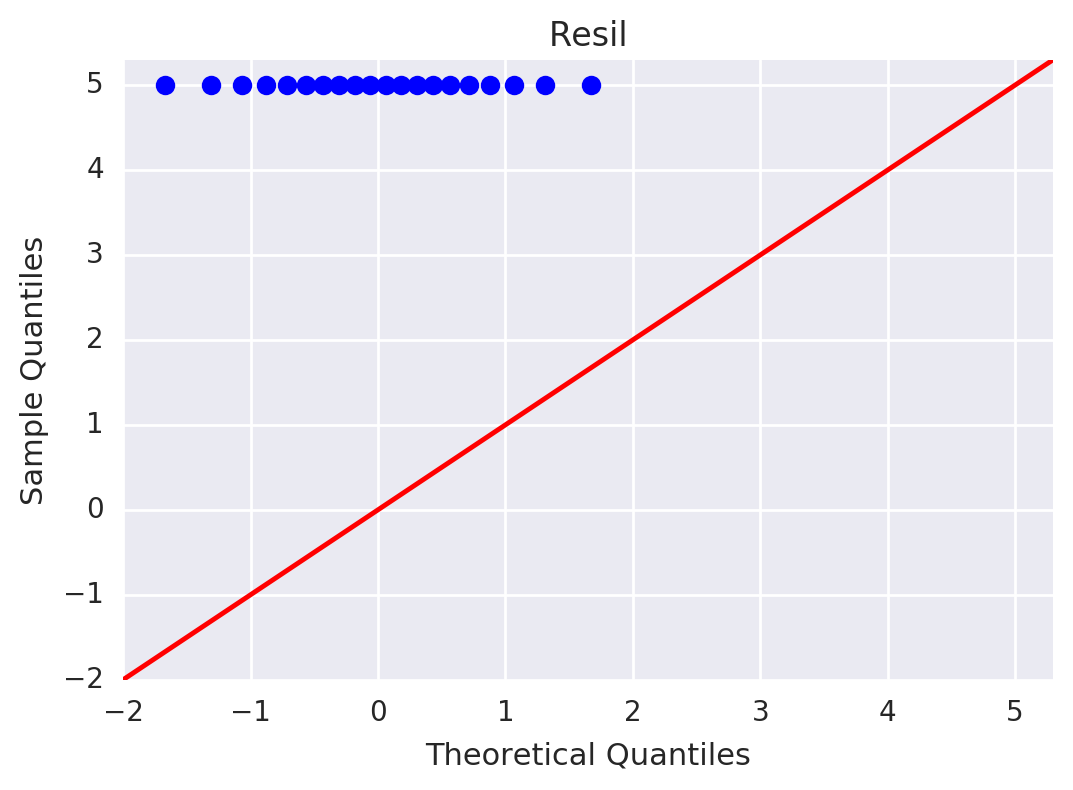

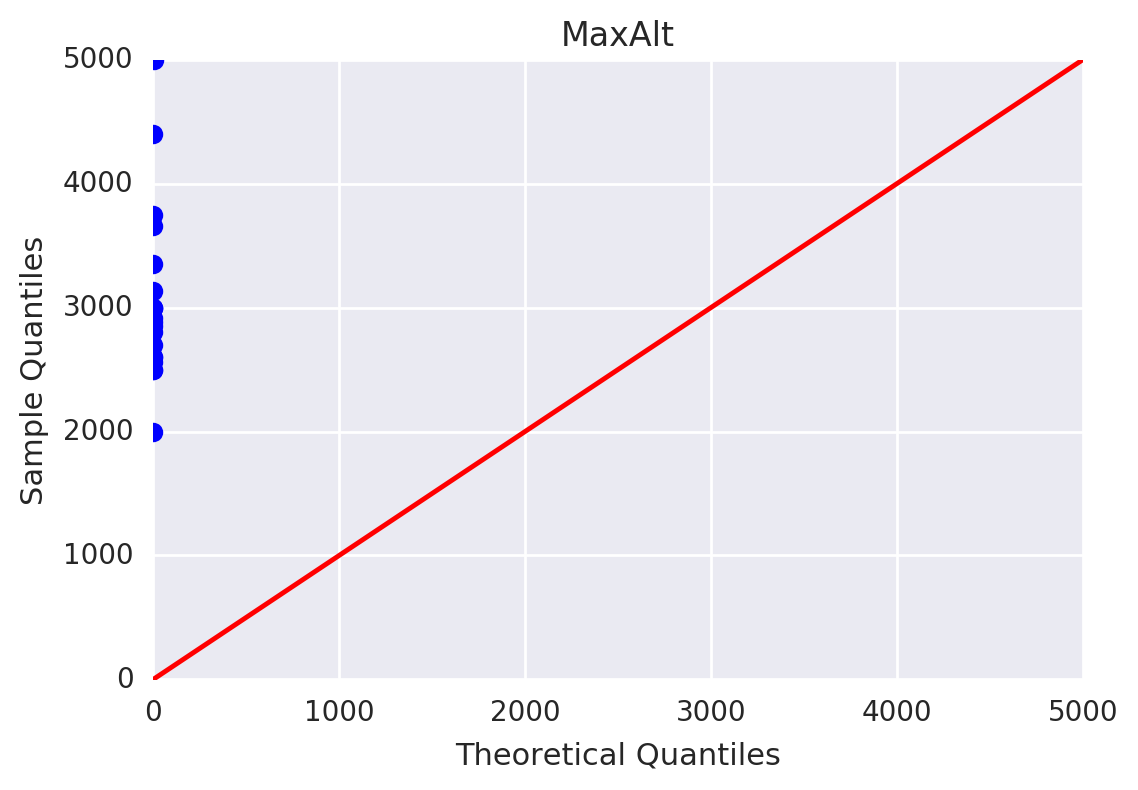

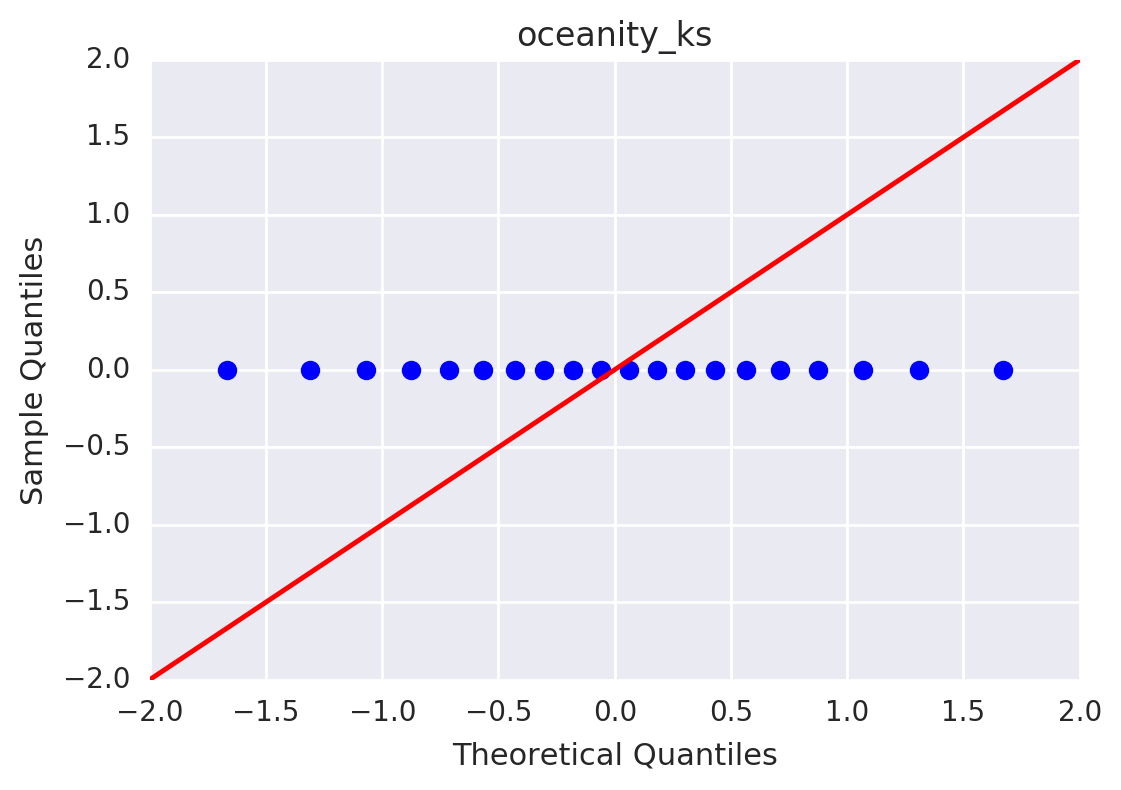

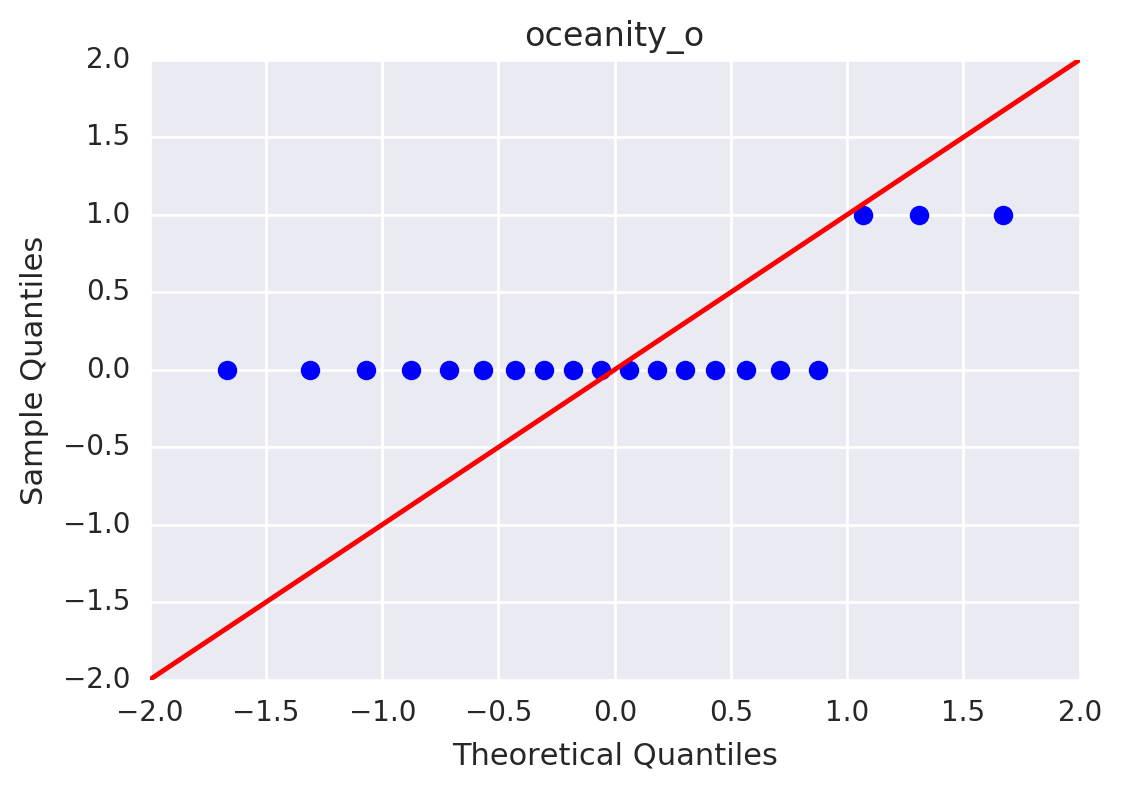

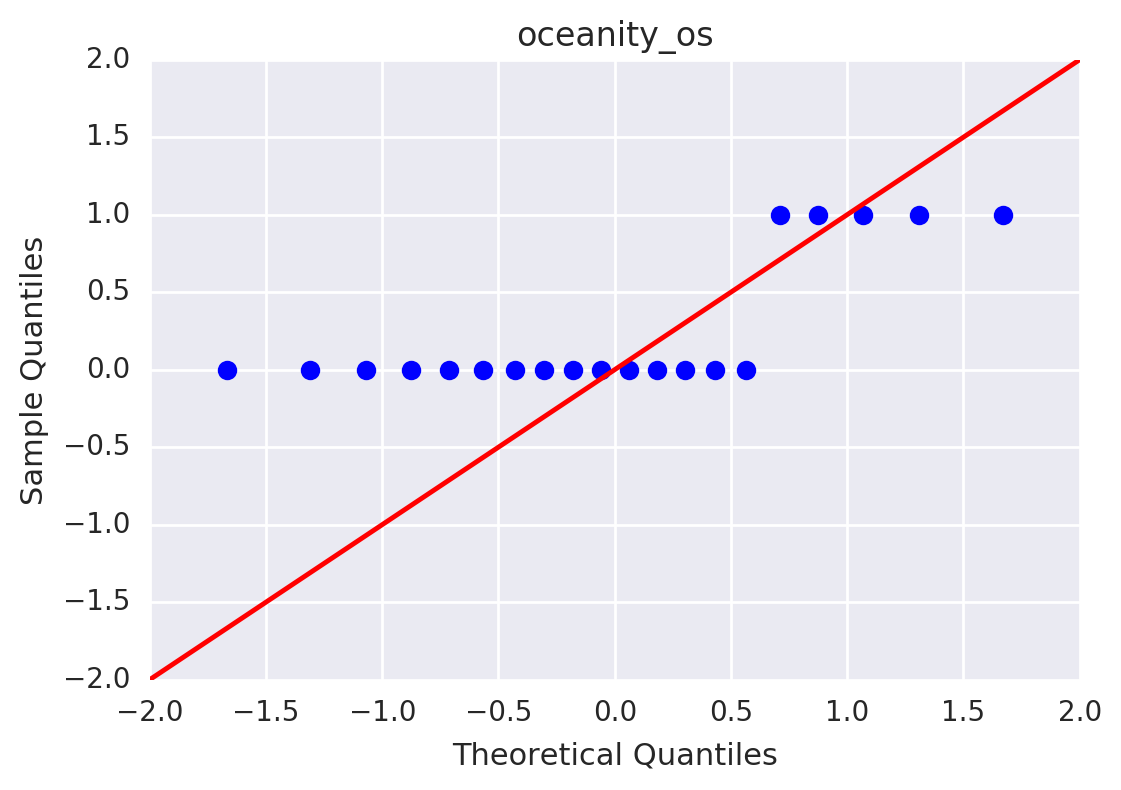

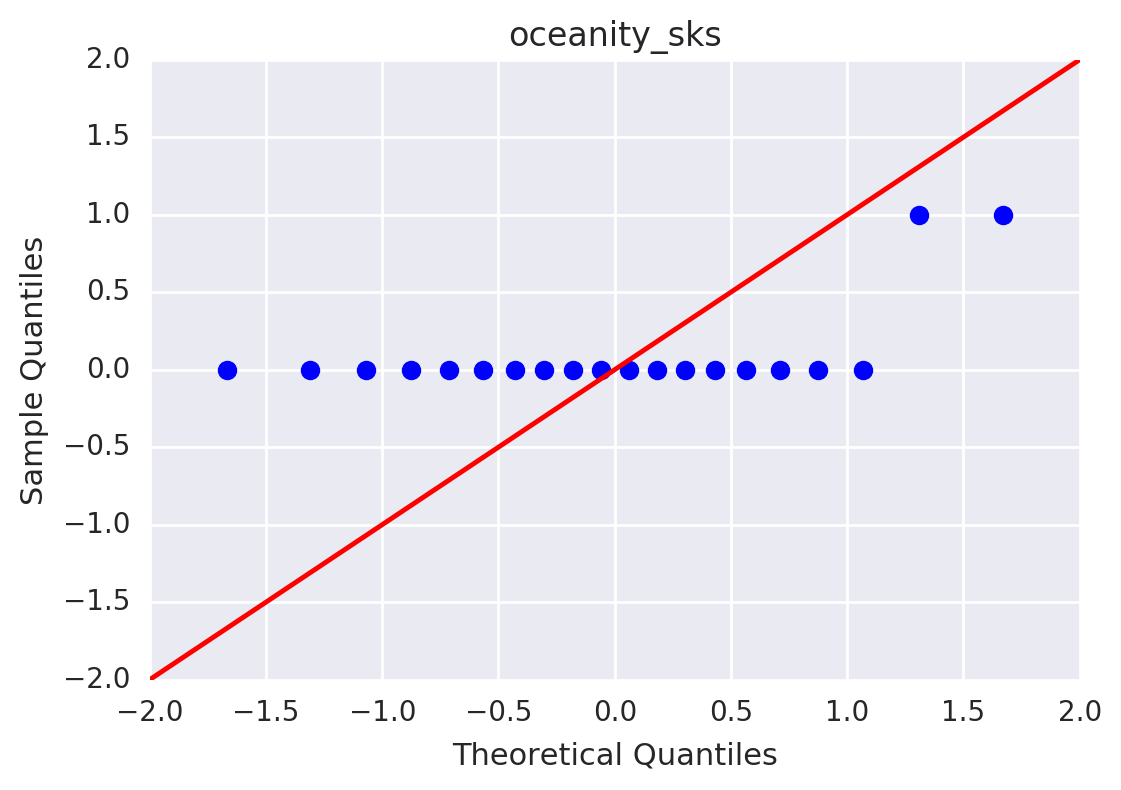

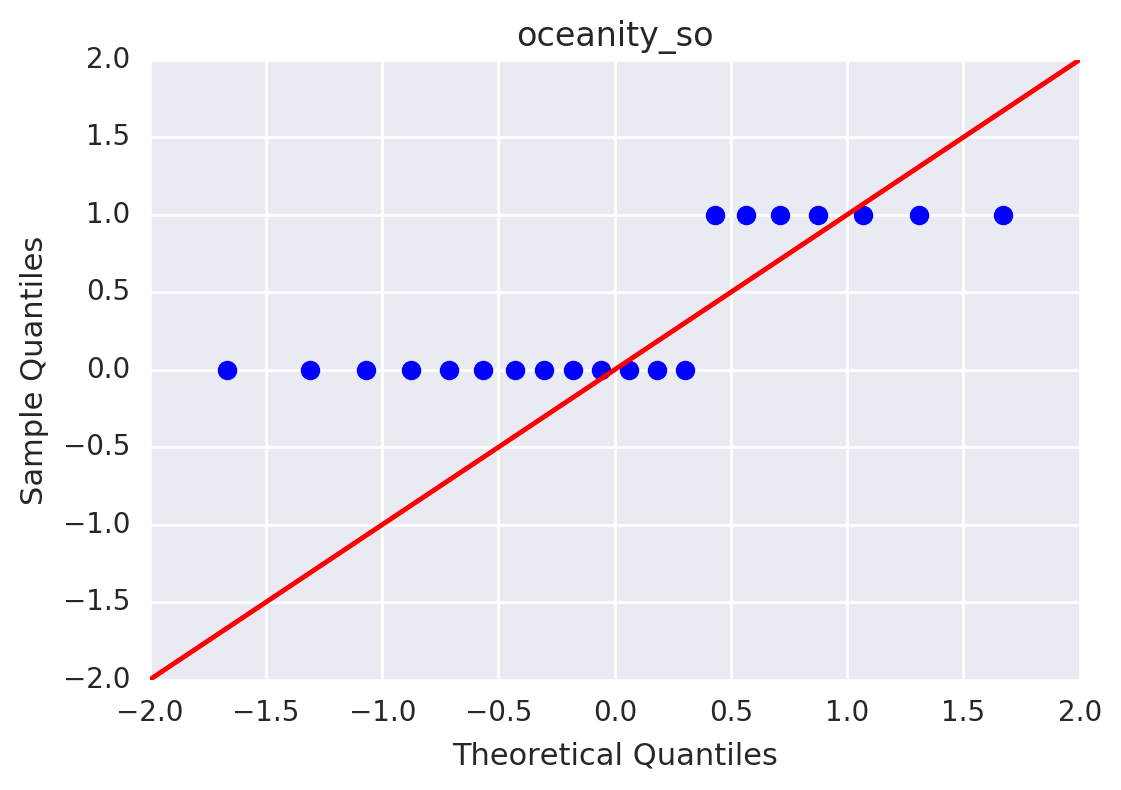

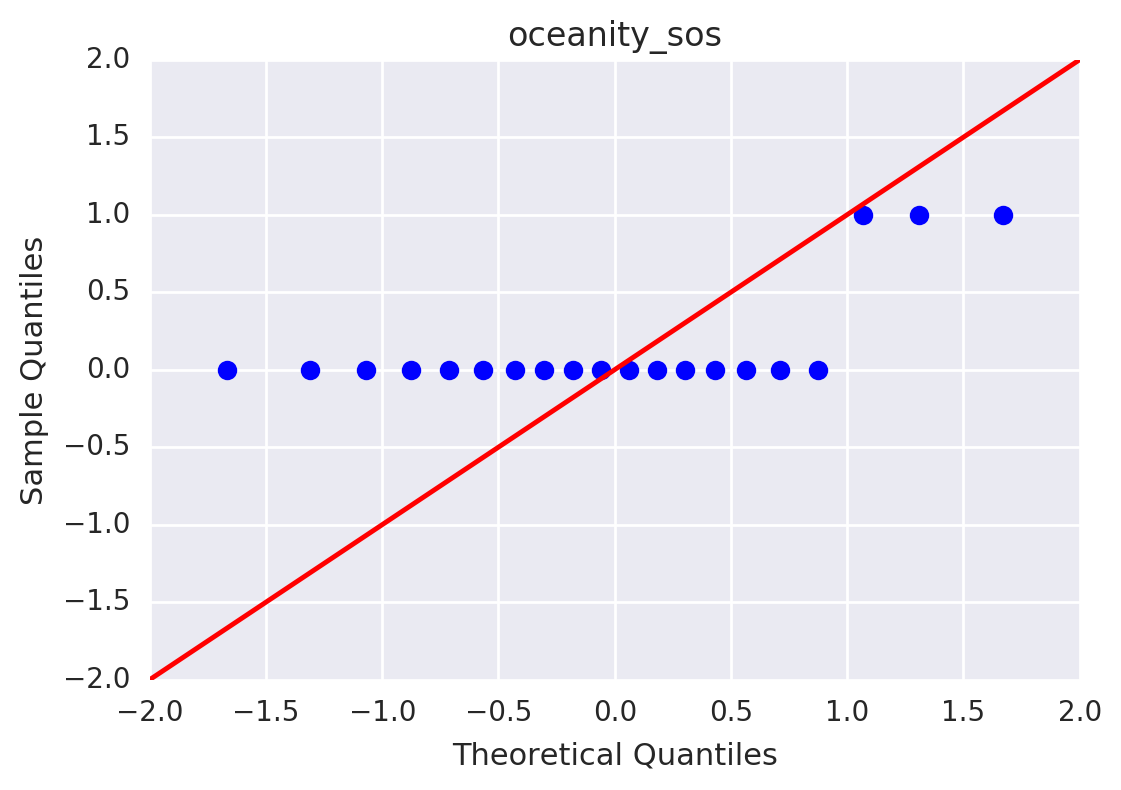

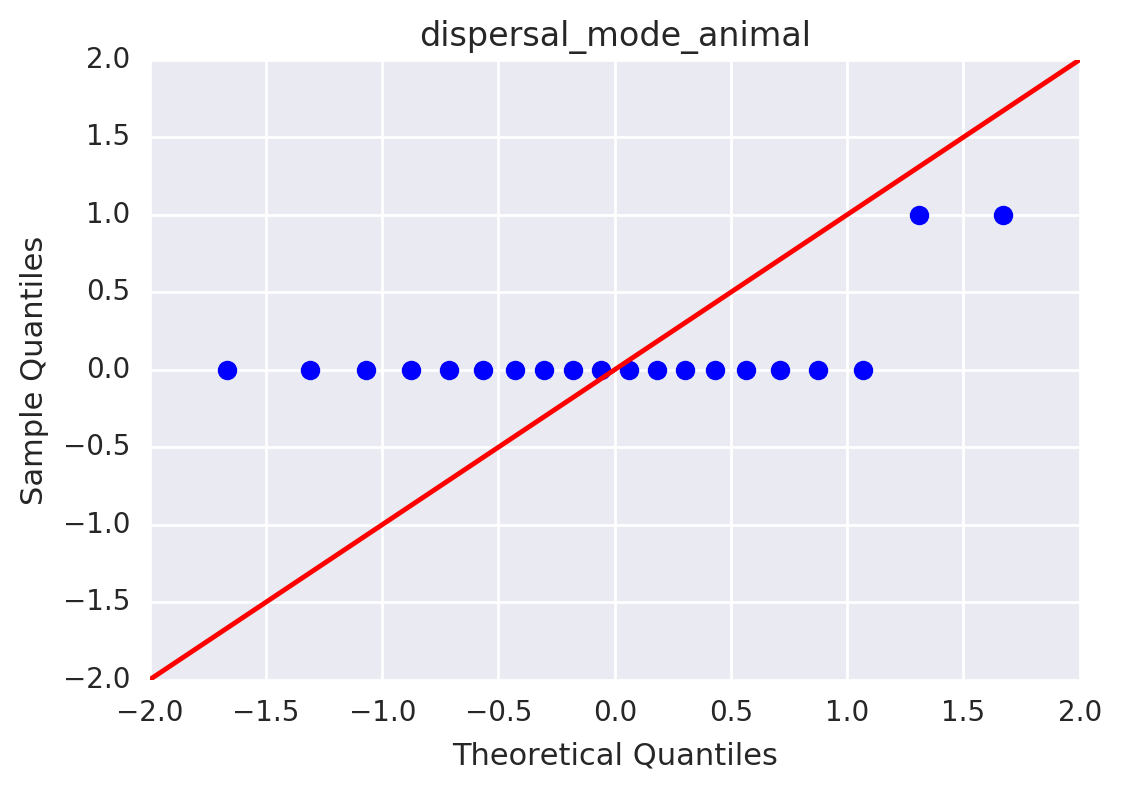

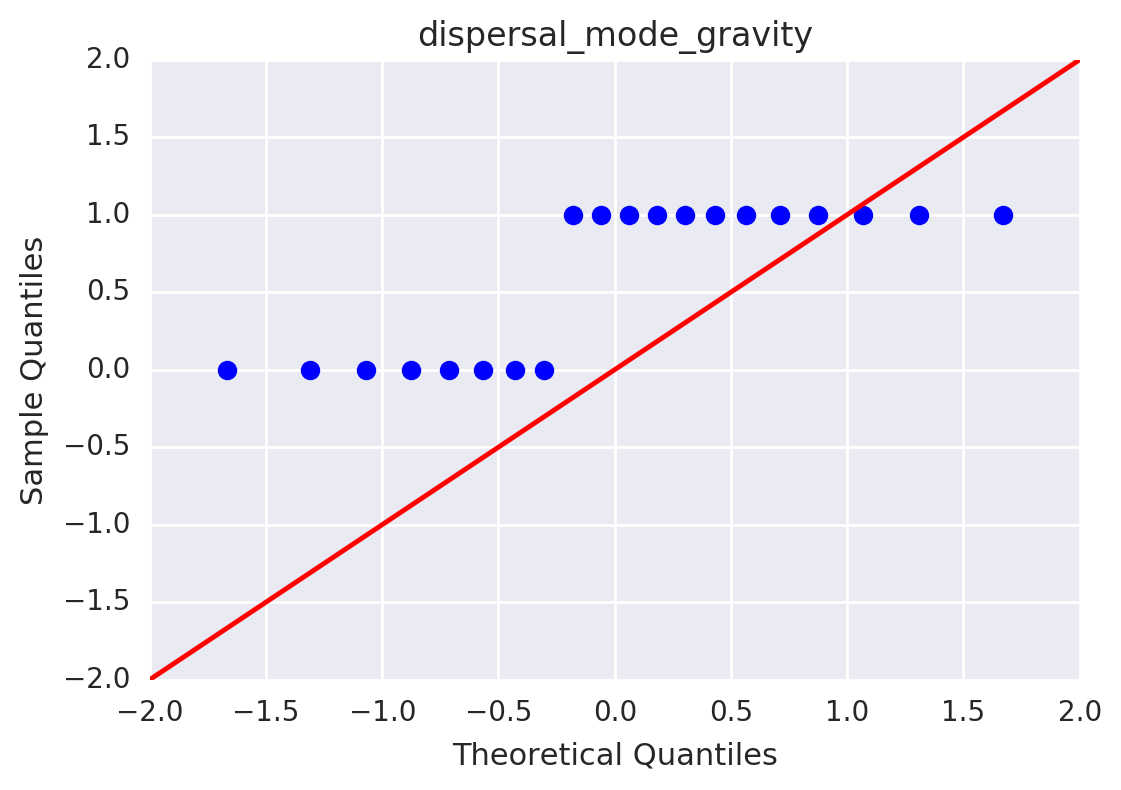

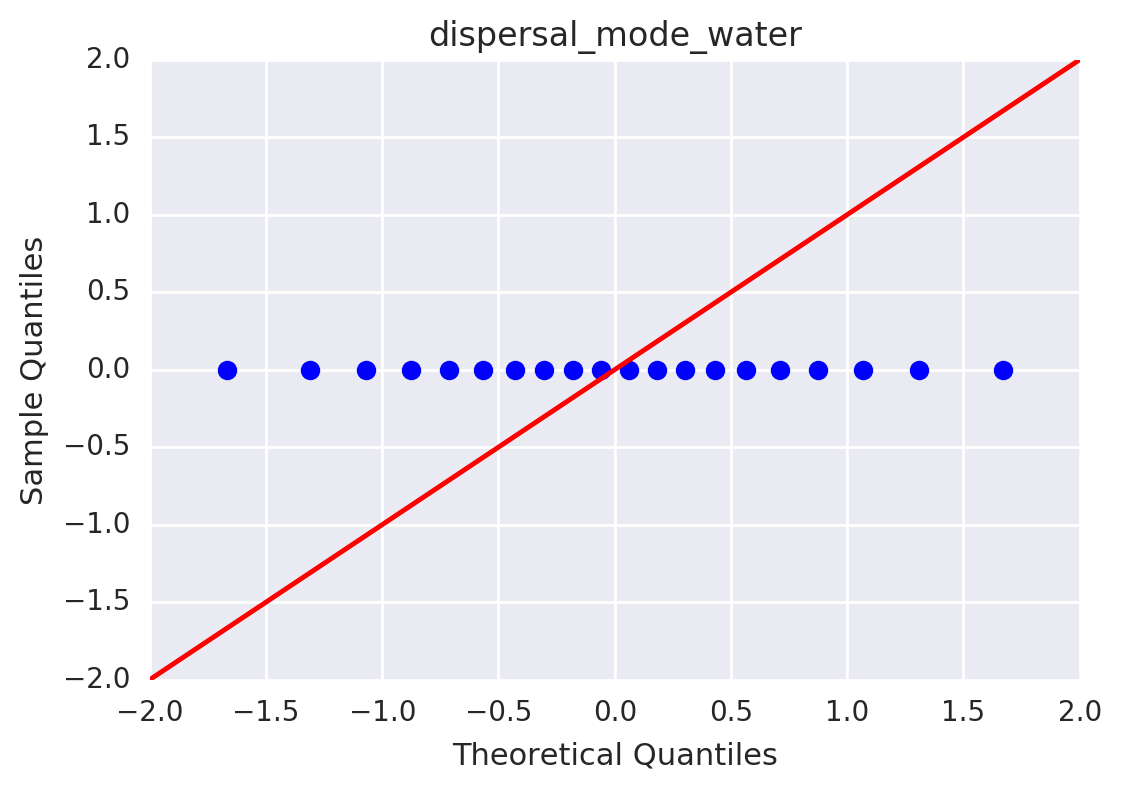

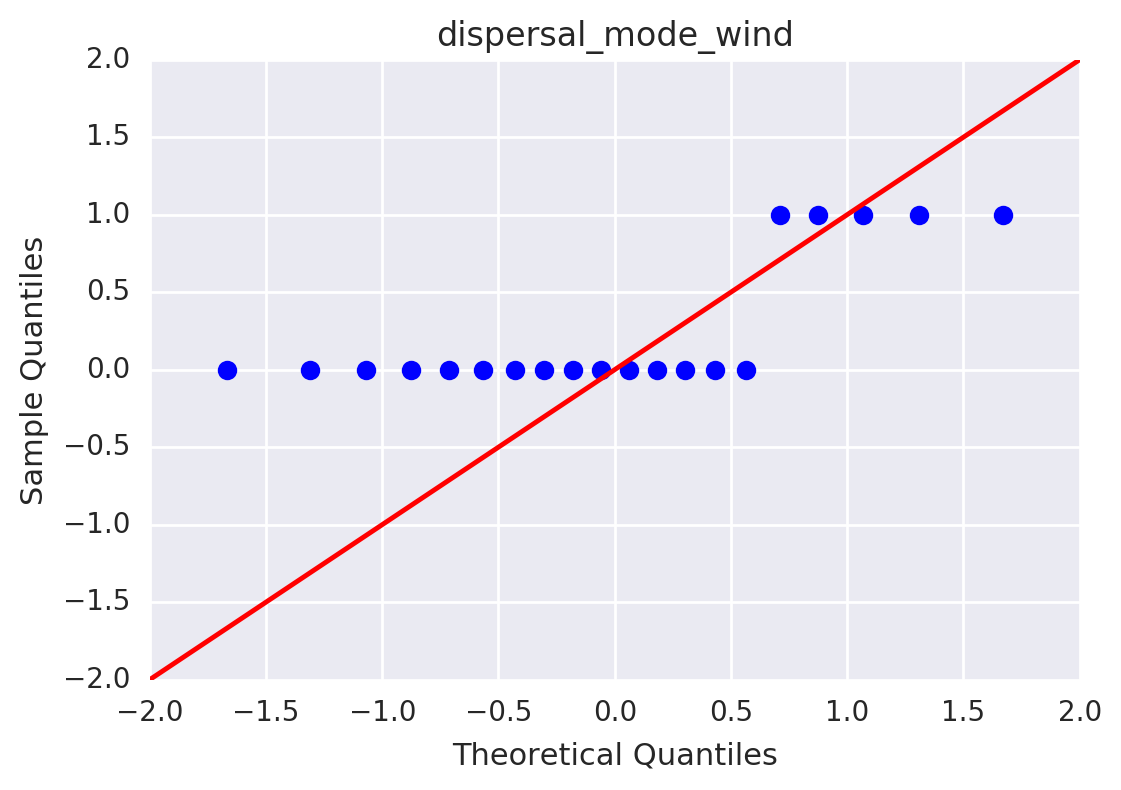

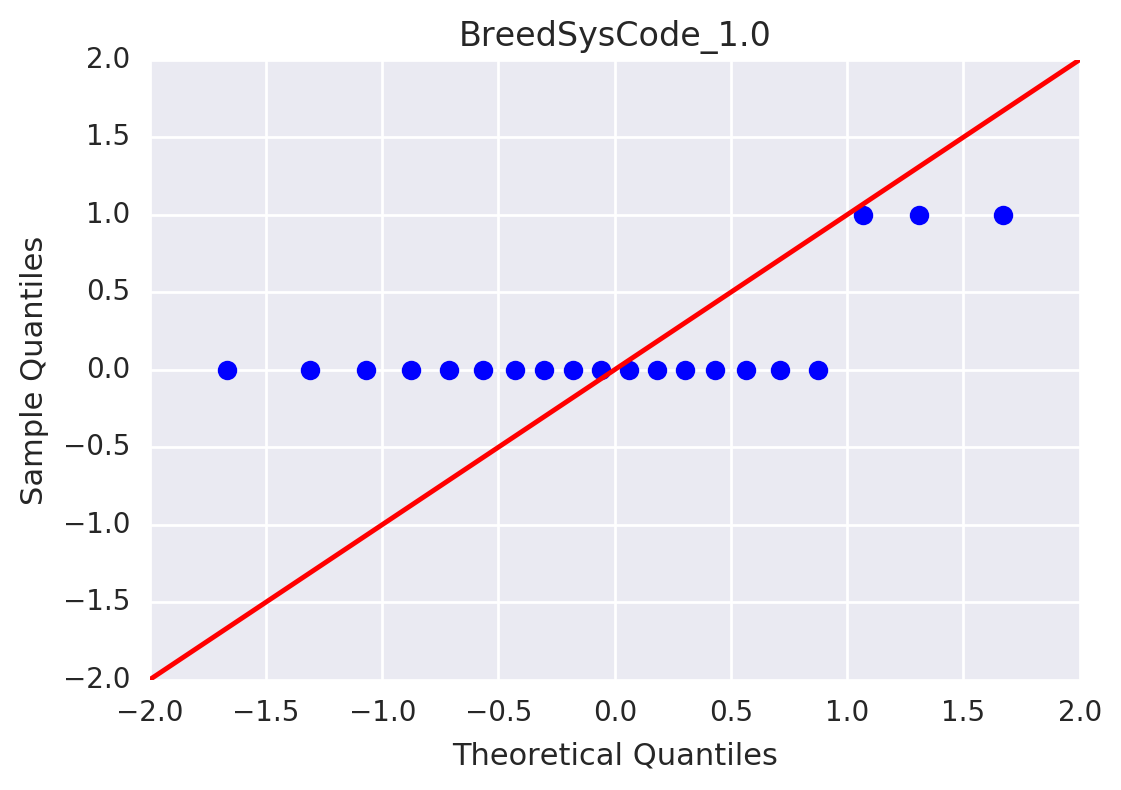

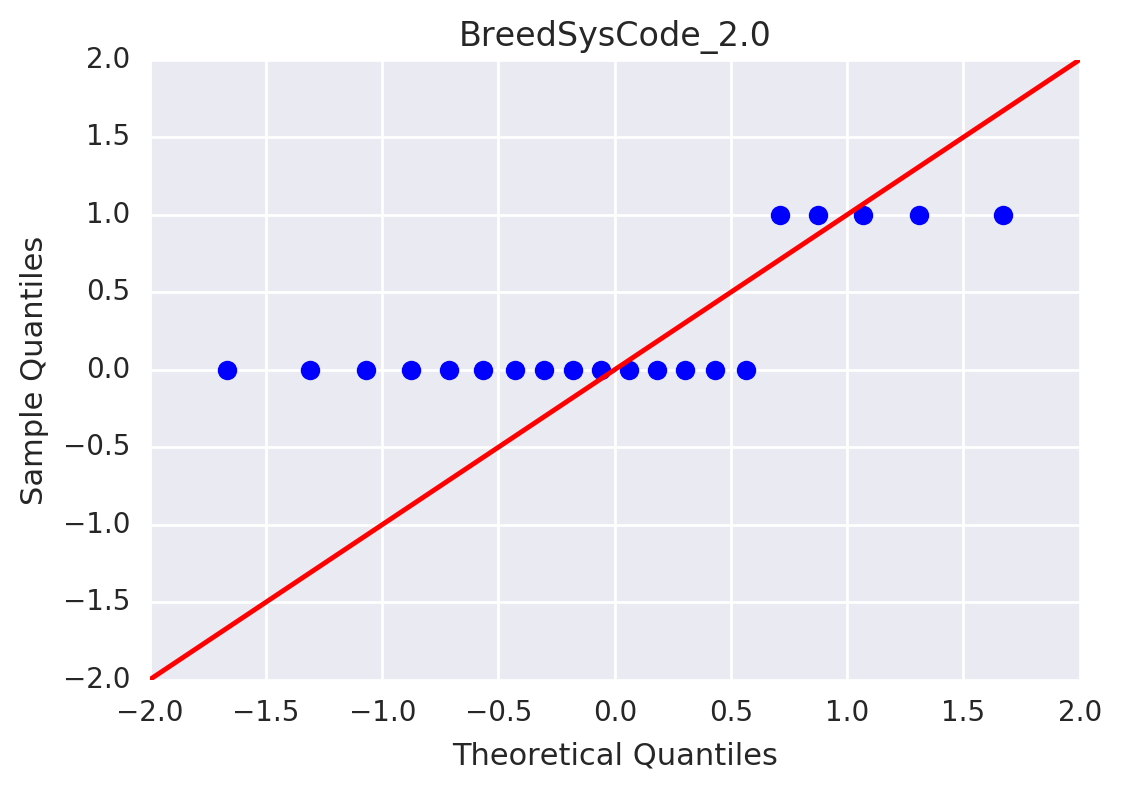

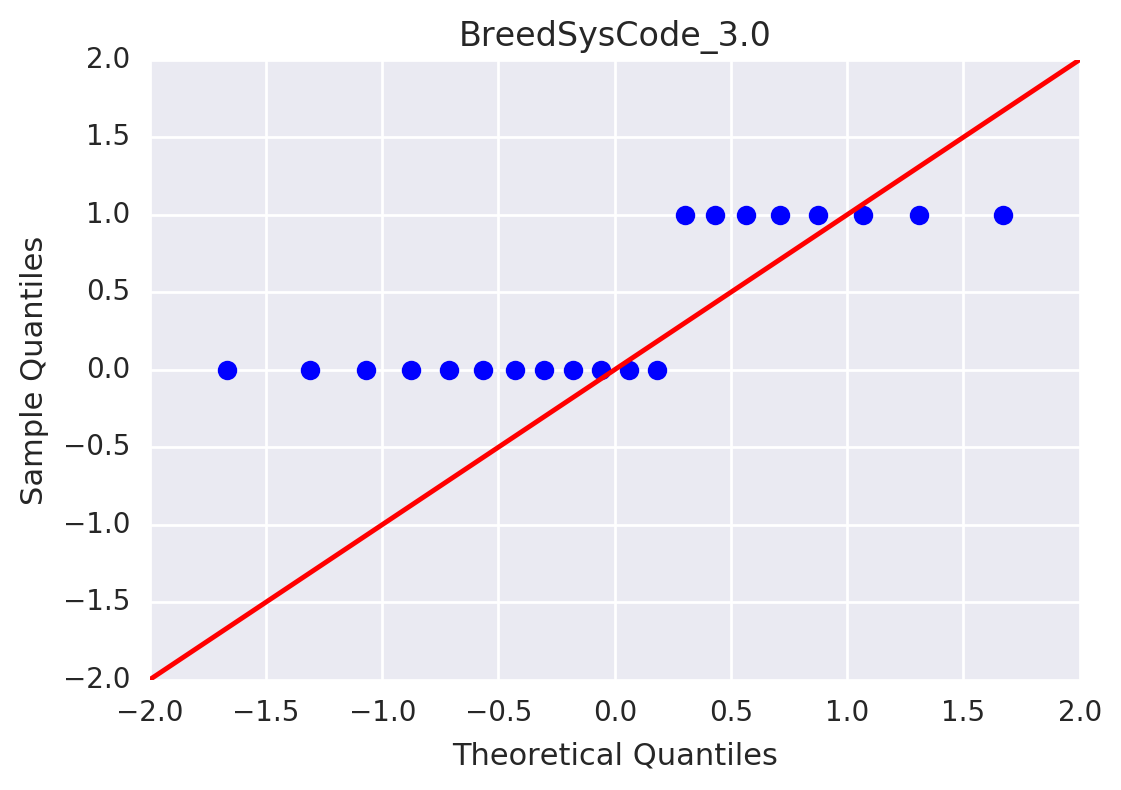

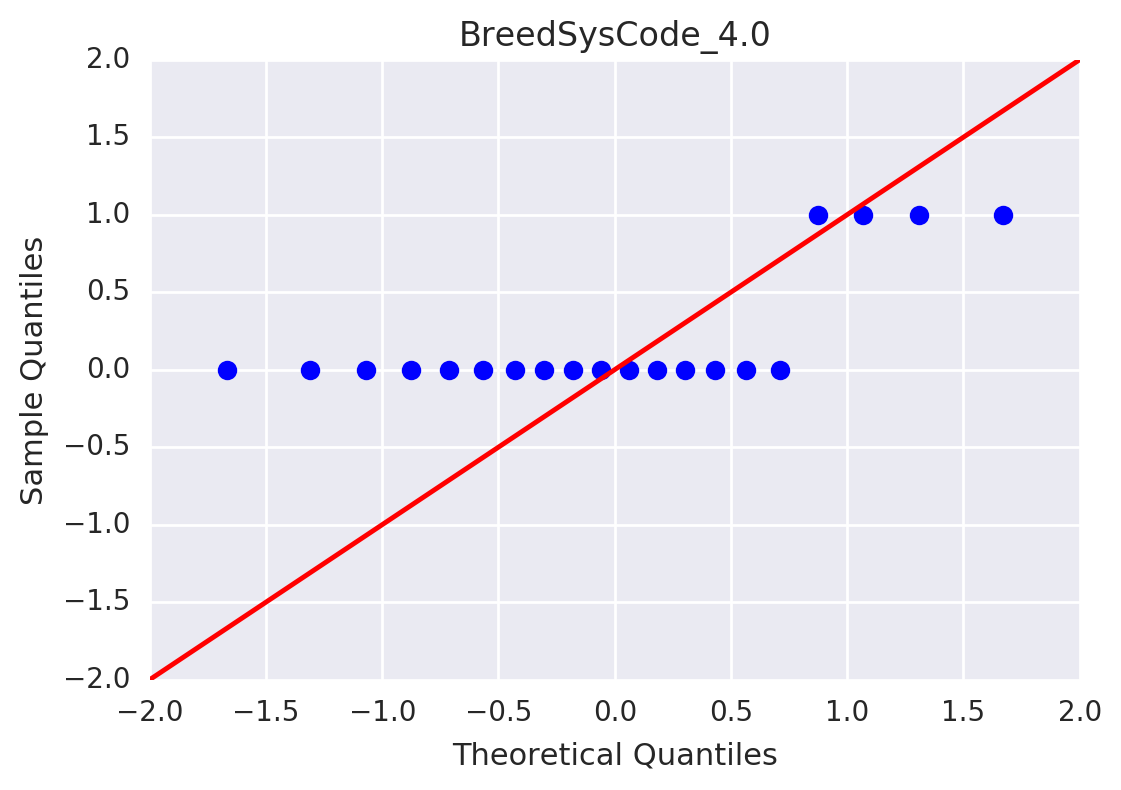

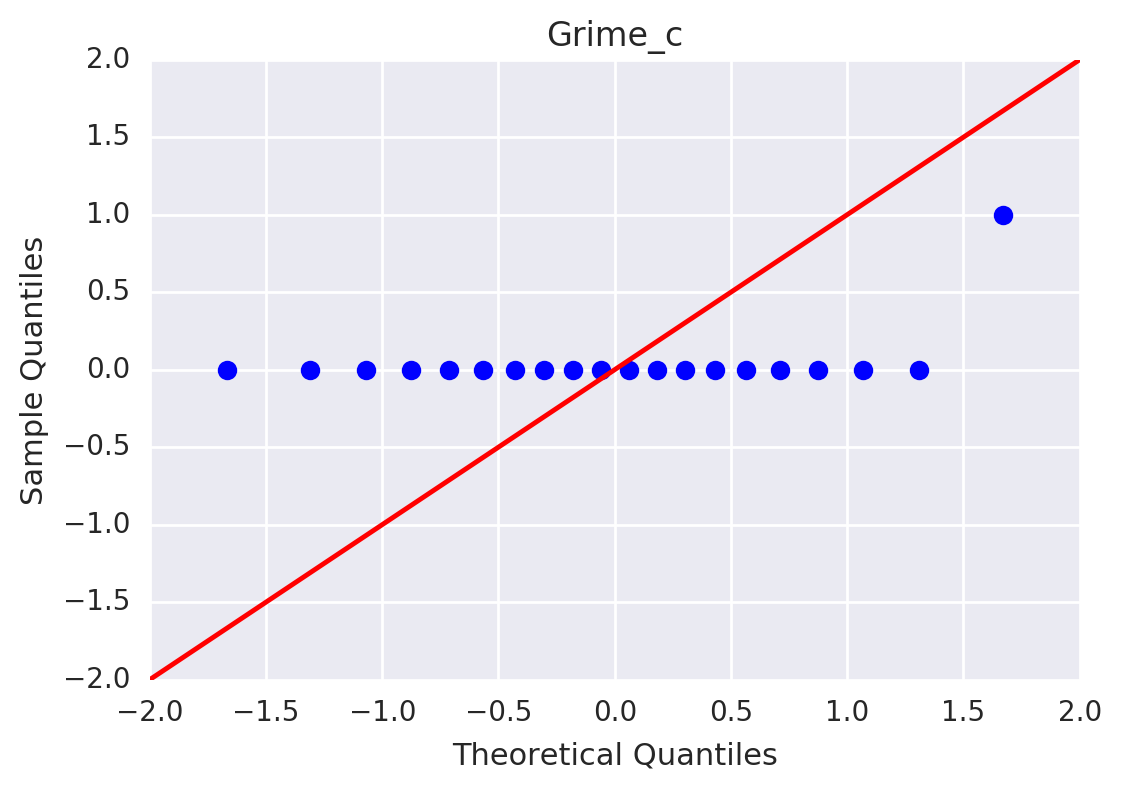

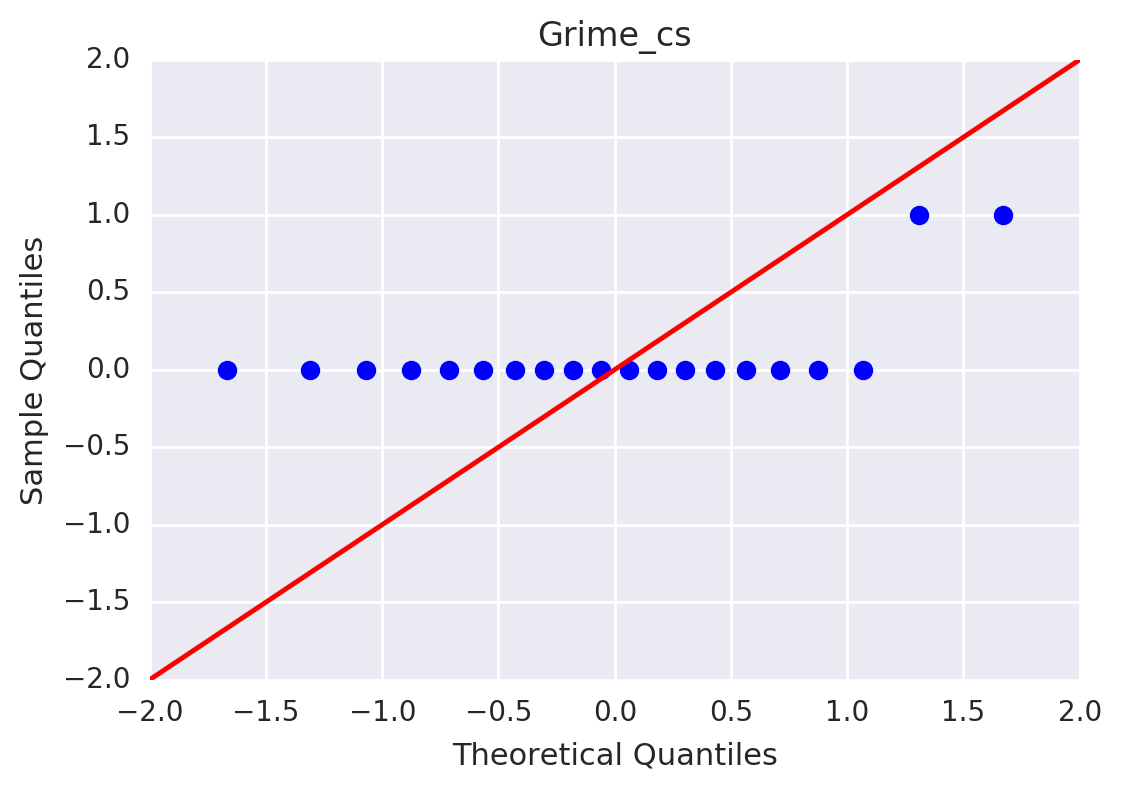

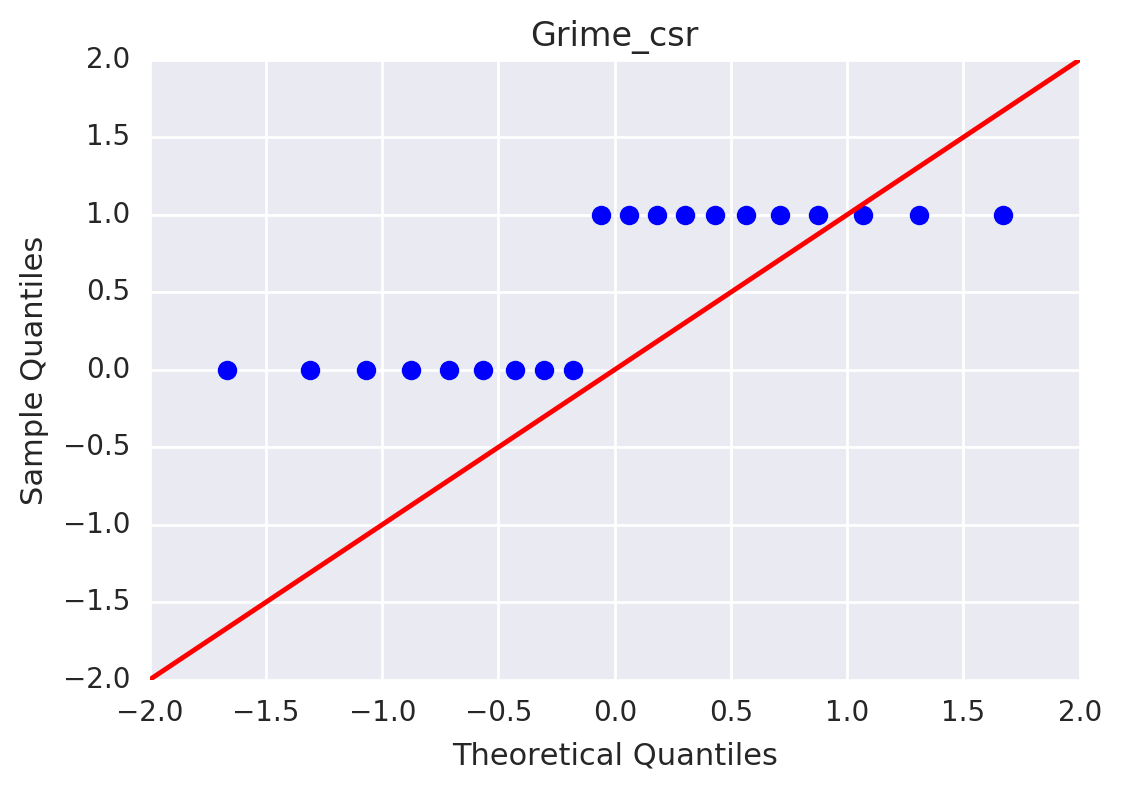

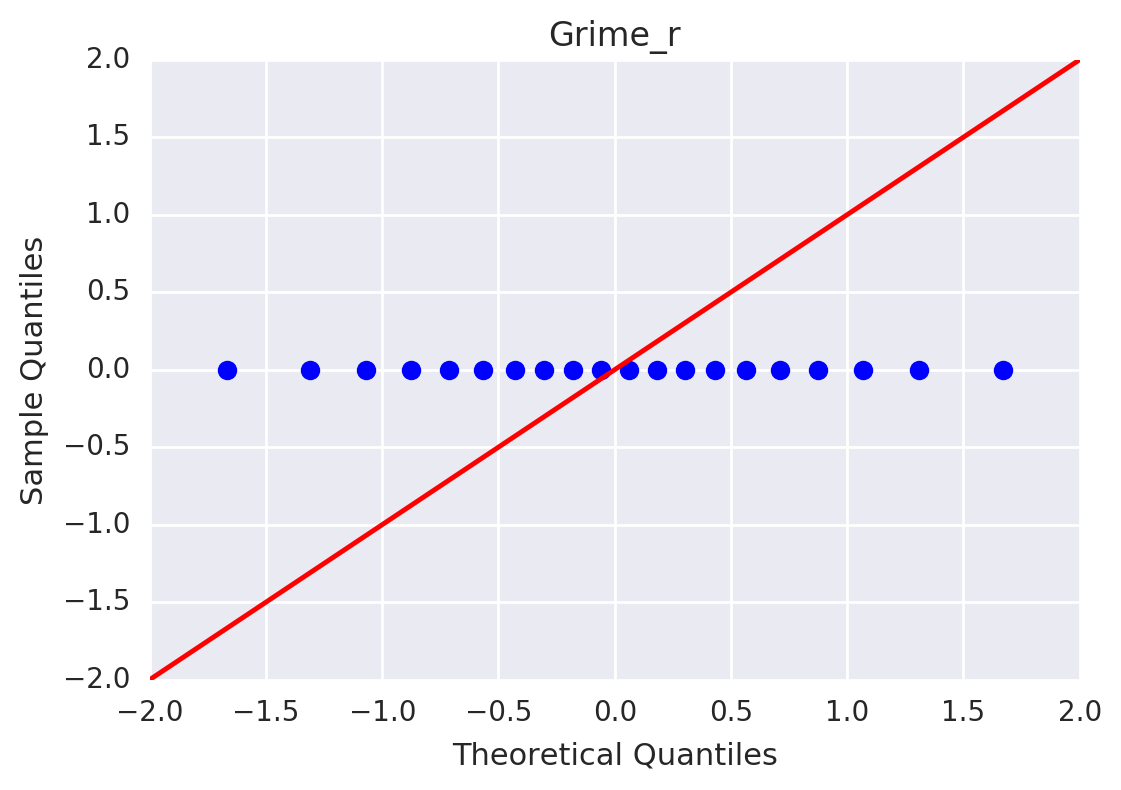

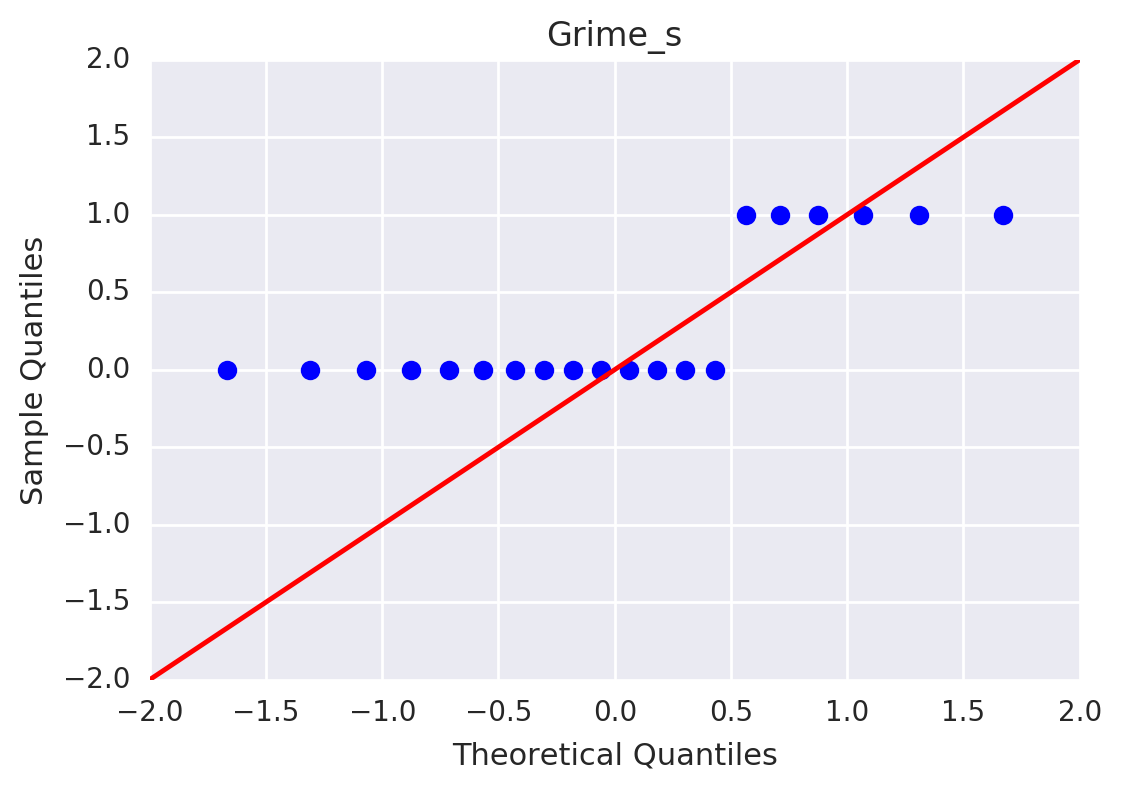

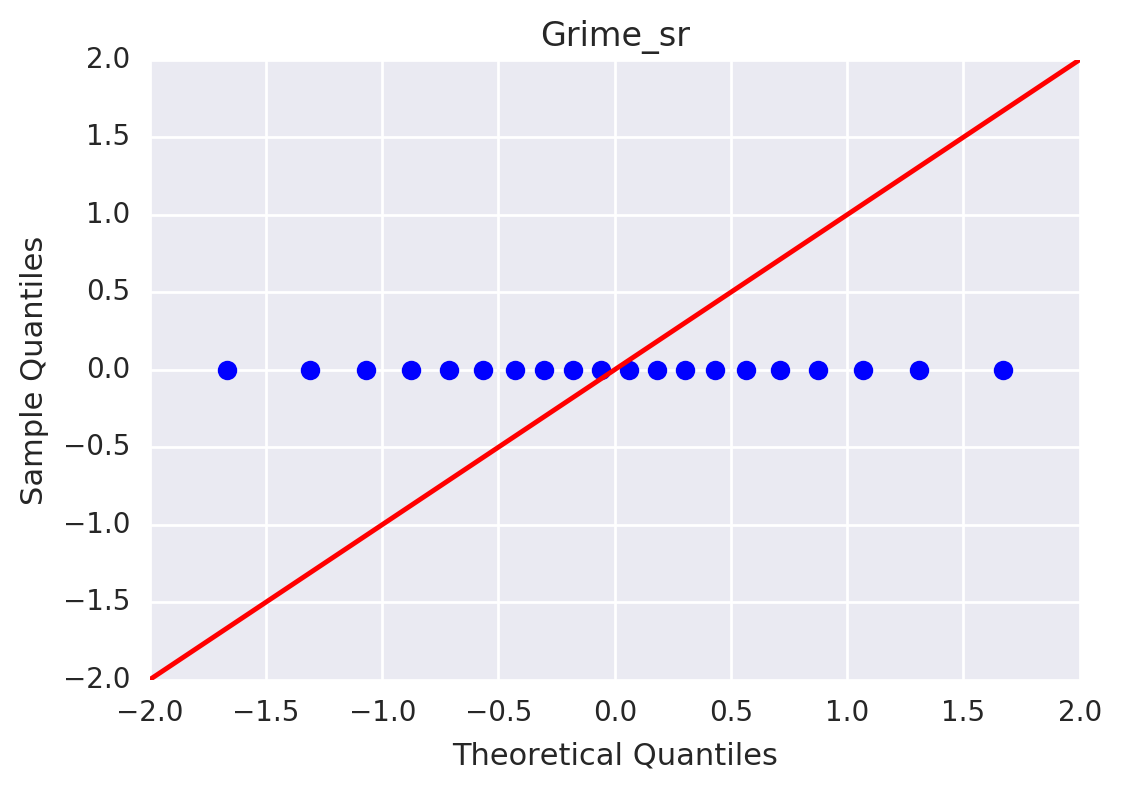

In [31]:
from statsmodels.graphics.gofplots import qqplot
for feature in features.columns.values:
    qqplot(features[feature], line='45')
    plt.title(feature)
    plt.show()